# Data process

In [1]:
import pandas as pd
import numpy as np
from time import time
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import copy
%matplotlib inline
plt.style.use('seaborn')

#Import data
pd.options.display.float_format = "{:.5f}".format
df = pd.read_csv('costsummarydayl2_201905101409.csv')
df.timedim = pd.to_datetime(df.timedim)

#drop useless data
df = df.drop([ "ys_tenant_uuid","ys_billingmonth", "payeraccountid","ys_custom_1","ys_custom_2","ys_custom_3",
              "ys_custom_4","ys_custom_5","ys_custom_6","ys_custom_7","ys_custom_8","ys_custom_9","ys_custom_10",
              "ys_custom_11","ys_custom_12","ys_custom_13","ys_custom_14","ys_custom_15","ys_custom_16",
              "ys_custom_17","ys_custom_18","ys_custom_19","ys_custom_20","run_timestamp", "ys_updatedon"], axis=1)
df = df.drop(["blendedcost", "ys_usagequantity", "ys_reservedusagequantity", "linkedaccountid","ys_role", 
              "ys_customer","ys_costcenter","ys_compliance", "availabilityzone", "ys_instancetype", "ys_os", 
              "ys_tenancytype", "ys_reservedusagetype","usagetype","ys_usagetype","ys_operationgroup"], axis=1)
###################
#could consider including past information of "blendedcost", "ys_usagequantity", "ys_reservedusagequantity" as features
###################

#one-hot encoding
data = pd.get_dummies(df)
encoded = list(data.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

#drop highly-correlated features
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
data=data.drop(data[to_drop], axis=1)
data.head()

646 total features after one-hot encoding.


timedim  usagequantity  unblendedcost  \
0 2019-01-01         986.00           0.00   
1 2019-01-01         602.00           0.00   
2 2019-01-01         583.00           0.00   
3 2019-01-01           0.03           0.03   
4 2019-01-01           0.10           0.10   

   productname_APN Annual Program Fee  productname_AWS Budgets  \
0                                   0                        0   
1                                   0                        0   
2                                   0                        0   
3                                   0                        0   
4                                   0                        0   

   productname_AWS CloudTrail  productname_AWS Config  \
0                           1                       0   
1                           1                       0   
2                           1                       0   
3                           0                       0   
4                           0                       0   

   productname_AWS Cost Explorer  productname_AWS Glue  \
0                              0                     0   
1                              0                     0   
2                              0                     0   
3                              0                     0   
4                              0                     0   

   productname_AWS Key Management Service  ...  \
0                                       0  ...   
1                                       0  ...   
2                                       0  ...   
3                                       1  ...   
4                                       1  ...   

   ys_project_yotascale-cost-processing  ys_project_yotascale-dev-playground  \
0                                     0                                    0   
1                                     0                                    0   
2                                     0                                    0   
3                                     0                                    0   
4                                     0                                    0   

   ys_project_yotascale-exports  ys_project_yotascale-forecasting-emr-logs  \
0                             0                                          0   
1                             0                                          0   
2                             0                                          0   
3                             0                                          0   
4                             0                                          0   

   ys_project_yotascale-staging-2  ys_project_yotascale-terraform-state  \
0                               0                                     0   
1                               0                                     0   
2                               0                                     0   
3                               0                                     0   
4                               0                                     0   

   ys_project_yotascale-weekly-cost-report  ys_project_zookeeper-playground  \
0                                        0                                0   
1                                        0                                0   
2                                        0                                0   
3                                        0                                0   
4                                        0                                0   

   ys_type_Cost  reservedinstance_N  
0             1                   1  
1             1                   1  
2             1                   1  
3             1                   1  
4             1                   1  

[5 rows x 533 columns]

In [2]:
#drop negative data
data=data[data.unblendedcost>=0]
#data=data[data.usagequantity>=0]

In [3]:
#drop 1 extreme data (formal data)
data2=data[data.unblendedcost<data.unblendedcost.max()]
#drop other extreme data as training set
data3=data2[data2.unblendedcost<=5*data2.unblendedcost.std()+data2.unblendedcost.mean()]

# Daily aggregated data analysis

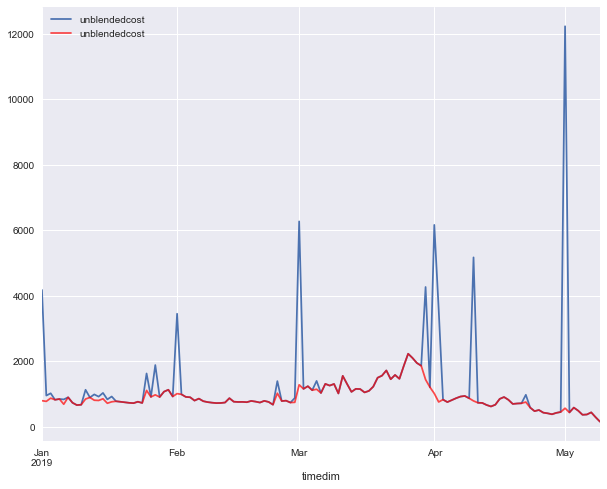

In [4]:
daily_data_final = data2.groupby('timedim')['timedim','unblendedcost'].sum().dropna()
ax = daily_data_final.plot(label='real data',figsize=(10,8))
daily_data_for_train = data3.groupby('timedim')['timedim','unblendedcost'].sum().dropna()
daily_data_for_train.plot(ax=ax,label='remove extreme data', alpha=0.7, color='red')
plt.legend()
plt.show()

## ARIMA

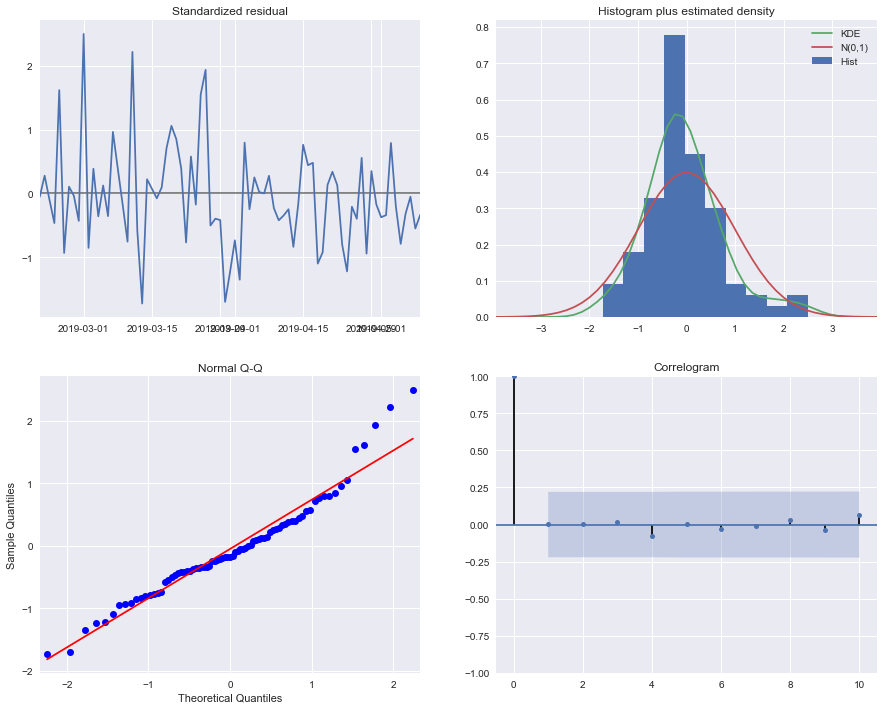

In [5]:
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore") # specify to ignore warning messages

warnings.filterwarnings("ignore")
mod = sm.tsa.statespace.SARIMAX(daily_data_for_train,
                                    order = (2, 0, 4),
                                    seasonal_order = (3, 1, 2, 12),
                                    enforce_stationarity = False,
                                    enforce_invertibility = False)
results = mod.fit()
results.plot_diagnostics(figsize=(15,12))
plt.show()

In [6]:
#make prediction with test data (including extreme values)
train_size = int(len(daily_data_final) * 0.60)
train, test = daily_data_final[0:train_size], daily_data_final[train_size:]

pred = results.get_prediction(start = test.iloc[0].name, dynamic = False)
pred_ci = pred.conf_int()

### model result with real data (including extreme values)

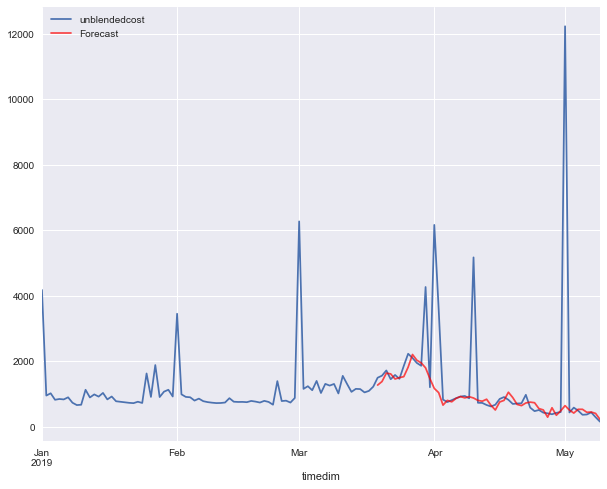

In [7]:
ax = daily_data_final.plot(label='actual', figsize=(10,8))
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.7, color='red')
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
r_squared = r2_score(test, pred.predicted_mean)
print('R^2 {}'.format(r_squared))
mse = mean_squared_error(test, pred.predicted_mean)
print('mse {}'.format(mse))
#standardized rmse
#accuracy according to perspective and product (mape)(*)

R^2 0.003199450468882481
mse 3671930.2319626105


### model results of data without extreme values

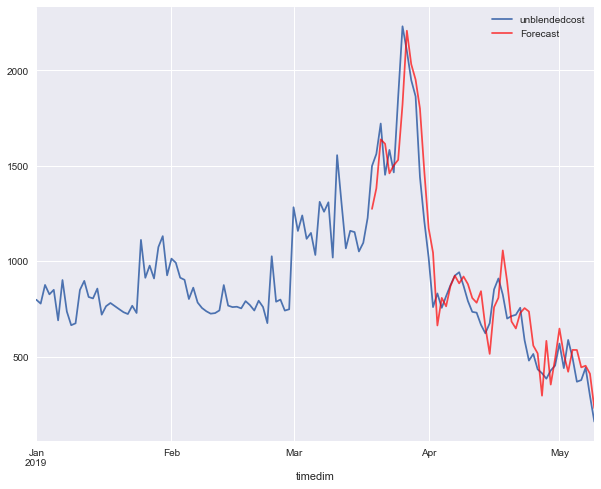

R^2 0.9089171571710485
mse 23491.434520769977


In [9]:
ax = daily_data_for_train.plot(label='actual', figsize=(10,8))
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=0.7, color='red')
plt.legend()
plt.show()

r_squared = r2_score(daily_data_for_train[train_size:], pred.predicted_mean)
print('R^2 {}'.format(r_squared))
mse = mean_squared_error(daily_data_for_train[train_size:], pred.predicted_mean)
print('mse {}'.format(mse))

negative R squared: The idea behind a negative value is that you'd have been closer to the actual values had you just predicted the mean each time (which would correspond to an r2 = 0).  
- Problem: in-sample prediction, work as baseline?
- possible solution: rolling window to make out-sample forecast.
- according to productname, for each product estimate one arima? not enough data points for some products.

## RNN: only on y
### model training

In [71]:
import tensorflow as tf
from tensorflow.python import keras

def model_train_param(parameters):
    #train on data without extreme values
    Y=daily_data_for_train['unblendedcost']

    y=Y[:train_size]
    n_steps = parameters[0]

    train_x = np.array(y[:-1])
    train_y = np.array(y[1:])

    train_num=len(train_x)

    X_train = []
    Y_train = []
    for i in range(train_num-n_steps):
        X_train.append(train_x[i:i+n_steps].reshape(n_steps,-1))
        Y_train.append(train_y[i:i+n_steps].reshape(n_steps,-1))
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)

    #scale data
    Y_train,X_train=Y_train/1000,X_train/1000
    
    #print(Y_train.shape)
    #print(X_train.shape)

    input_tensor = keras.layers.Input((n_steps,1))
    hidden = keras.layers.LSTM(units=parameters[1],activation=parameters[2],return_sequences=True)(input_tensor)
    output = keras.layers.Dense(units=1,activation=None)(hidden)
    model = keras.models.Model(inputs = input_tensor,outputs = output)
    def loss_custom(y_true,y_pred):
        y_true_reshape = keras.backend.reshape(y_true,shape=(-1,n_steps))
        y_pred_reshape = keras.backend.reshape(y_pred,shape=(-1,n_steps))
        return keras.losses.mse(y_true_reshape,y_pred_reshape)
    adam = keras.optimizers.Adam(lr=parameters[3])
    sgd = keras.optimizers.SGD()
    #metrics=['mse']
    model.compile(optimizer=adam,loss='mse',metrics=['mse'])
    es = keras.callbacks.EarlyStopping(monitor='mean_squared_error', mode='min', verbose=1, patience=5)
    model.fit(X_train,Y_train,batch_size=16,epochs=1000,callbacks=[es],verbose=1)

    return model,X_train,Y_train

In [72]:
def model_overfitting_check(model,n_steps,X_train,Y_train):
    #make prediction with test data (out of sample)
    X_test = []
    Y_test = [] 
    test_x = np.array((daily_data_for_train['unblendedcost'])[train_size-n_steps:])
    test_num=len(test_x)
    for i in range(test_num-n_steps-1):
        X_test.append(test_x[i:i+n_steps].reshape(n_steps,-1))
        Y_test.append(test_x[i:i+n_steps].reshape(n_steps,-1))
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    X_test,Y_test =X_test/1000,Y_test/1000
    y_predict=model.predict(X_test)
    data_temp2=daily_data_final.iloc[train_size-1:train_size-n_steps+test_num-2,].copy()
    data_temp2.loc[:,'unblendedcost']=list((y_predict.reshape(-1))[list(range(n_steps-1,n_steps*(len(y_predict)+1)-1,n_steps))])
    data_temp2.unblendedcost*=1000
    # check overfitting
    predicted_train=model.predict(X_train)
    data_temp1=daily_data_final.iloc[n_steps:train_size-1,].copy()
    data_temp1.loc[:,'unblendedcost']=list((predicted_train.reshape(-1))[list(range(n_steps-1,n_steps*(len(predicted_train)+1)-1,n_steps))])
    data_temp1.unblendedcost*=1000
    
    ax = daily_data_for_train.plot(label='actual', figsize=(10,8))
    (data_temp1.unblendedcost).plot(ax=ax, label='Forecast', alpha=0.7, color='green')
    (data_temp2.unblendedcost).plot(ax=ax, label='Forecast', alpha=0.7, color='red')
    plt.legend()
    plt.show()
    
    print('in sample')
    r_squared1 = r2_score(daily_data_for_train.iloc[n_steps:train_size-1,], data_temp1.unblendedcost)
    print('R^2 {}'.format(r_squared1))
    mse1 = mean_squared_error(daily_data_for_train.iloc[n_steps:train_size-1,], data_temp1.unblendedcost)
    print('mse {}'.format(mse1))

    print('out of sample')
    r_squared2 = r2_score(daily_data_for_train.iloc[train_size-1:train_size-n_steps+test_num-2,], data_temp2.unblendedcost)
    print('R^2 {}'.format(r_squared2))
    mse2 = mean_squared_error(daily_data_for_train.iloc[train_size-1:train_size-n_steps+test_num-2,], data_temp2.unblendedcost)
    print('mse {}'.format(mse2))
    return [r_squared1,mse1,r_squared2,mse2]

### Grid Search

In [58]:
import itertools
n_steps_list=range(7,18,3)
units_list=[16,32,64]
activation_list=['tanh','relu']
lr_list=[0.0001,0.0003,0.001,0.003,0.01]

# Generate all different combinations

parameter_combination = list(itertools.product(n_steps_list, units_list, activation_list, lr_list))

In [59]:
grid_search_results=pd.DataFrame(columns=['n_step','unit','activ','lr','R_2_in','mse_in','R_2_out','mse_out'])

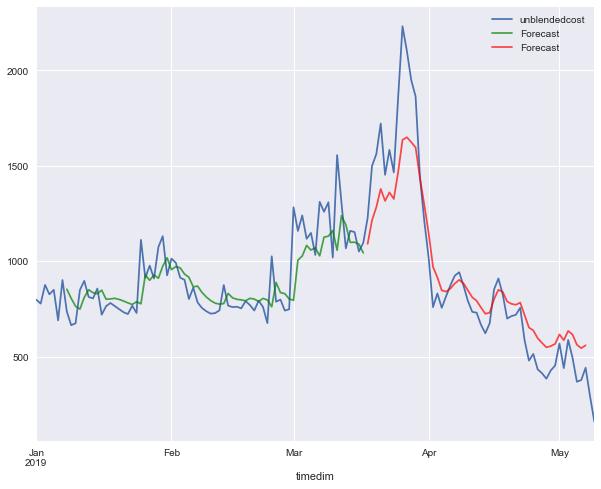

[7, 16, 'tanh', 0.0001]
Epoch 00822: early stopping


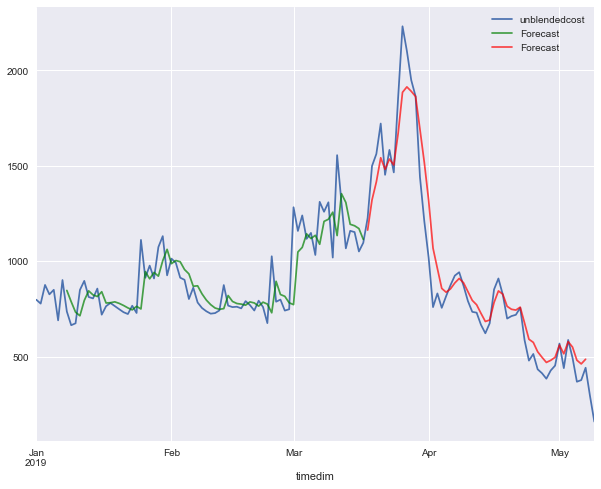

[7, 16, 'tanh', 0.0003]
Epoch 00214: early stopping


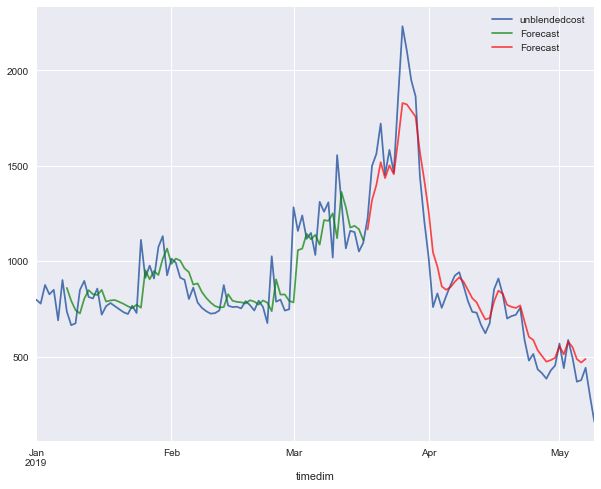

[7, 16, 'tanh', 0.001]
Epoch 00104: early stopping


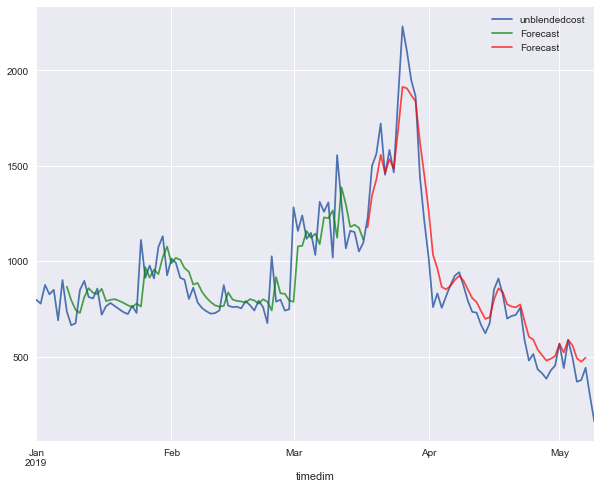

[7, 16, 'tanh', 0.003]
Epoch 00046: early stopping


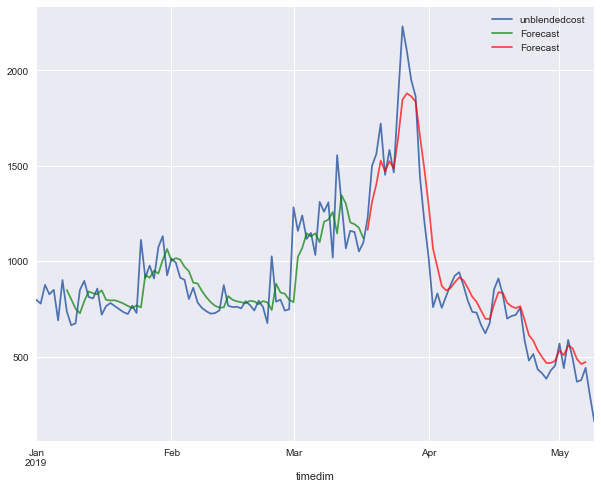

[7, 16, 'tanh', 0.01]


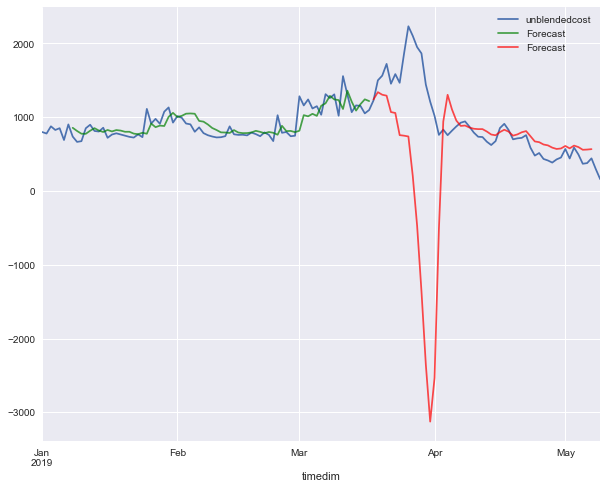

[7, 16, 'relu', 0.0001]
Epoch 00612: early stopping


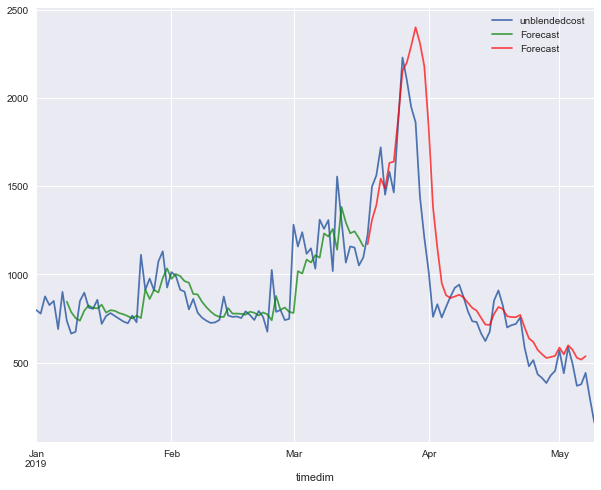

[7, 16, 'relu', 0.0003]
Epoch 00468: early stopping


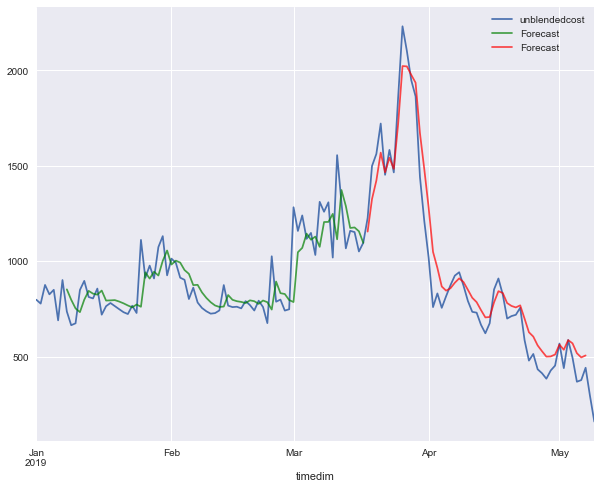

[7, 16, 'relu', 0.001]
Epoch 00155: early stopping


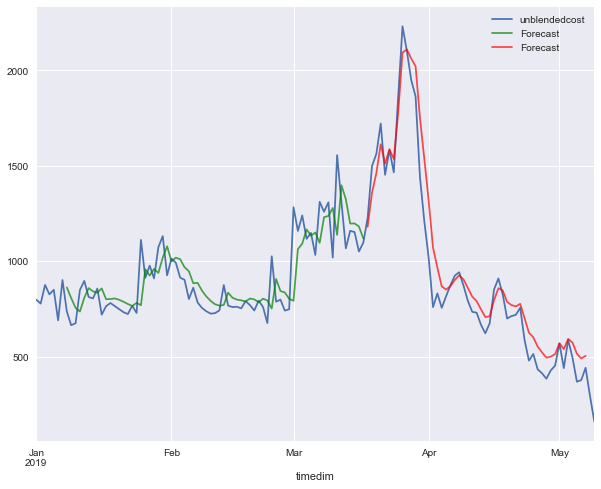

[7, 16, 'relu', 0.003]
Epoch 00083: early stopping


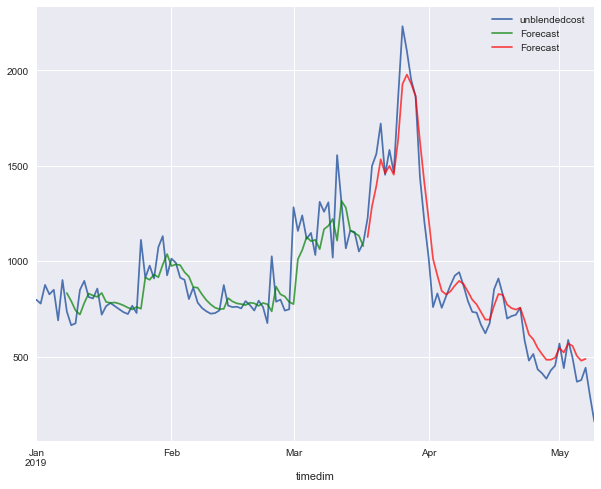

[7, 16, 'relu', 0.01]


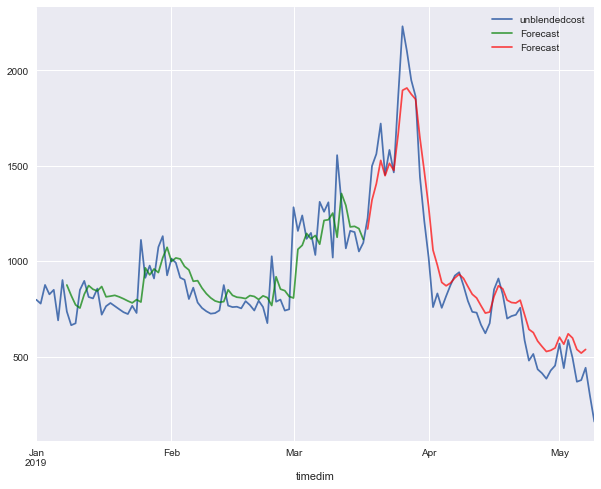

[7, 32, 'tanh', 0.0001]
Epoch 00546: early stopping


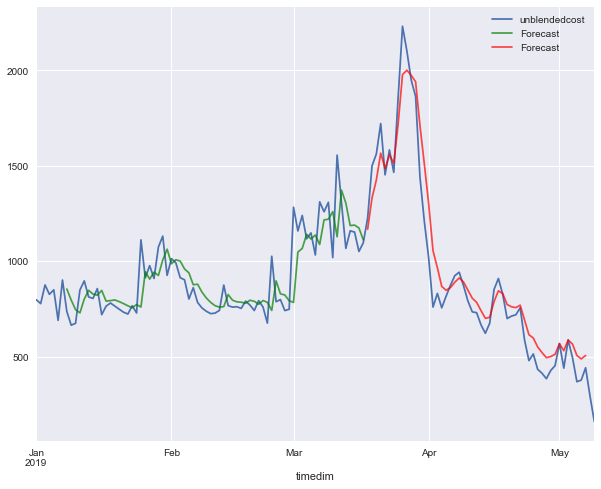

[7, 32, 'tanh', 0.0003]
Epoch 00163: early stopping


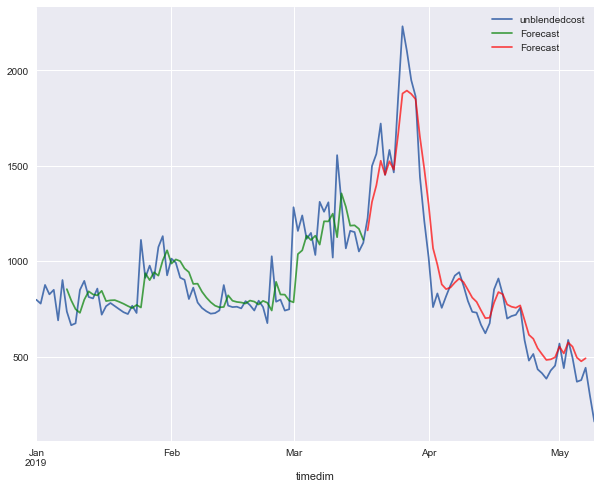

[7, 32, 'tanh', 0.001]
Epoch 00093: early stopping


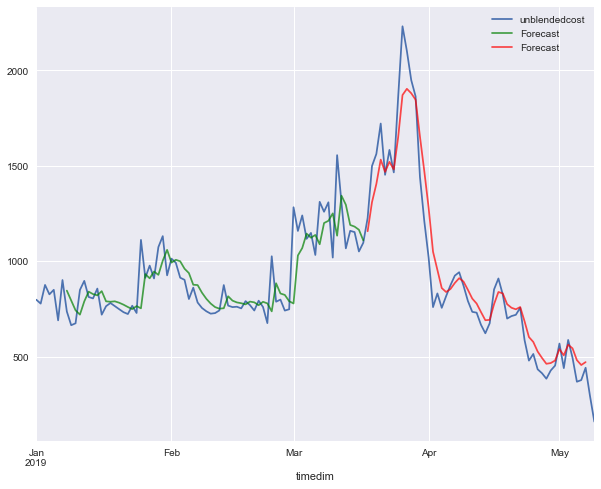

[7, 32, 'tanh', 0.003]
Epoch 00040: early stopping


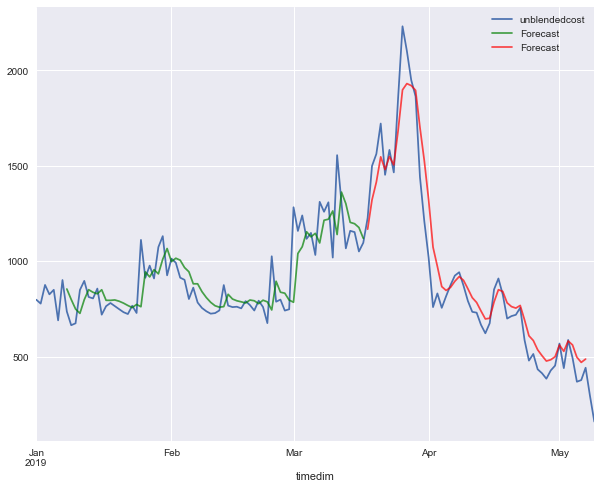

[7, 32, 'tanh', 0.01]


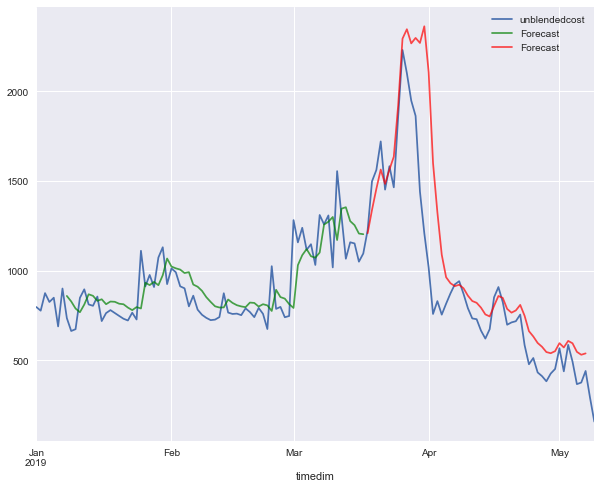

[7, 32, 'relu', 0.0001]
Epoch 00625: early stopping


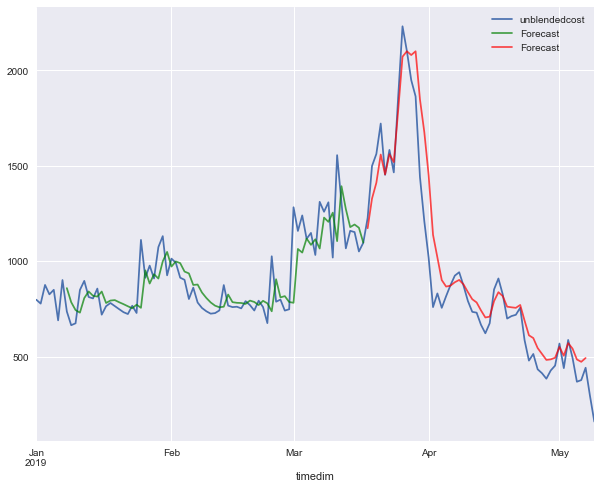

[7, 32, 'relu', 0.0003]
Epoch 00232: early stopping


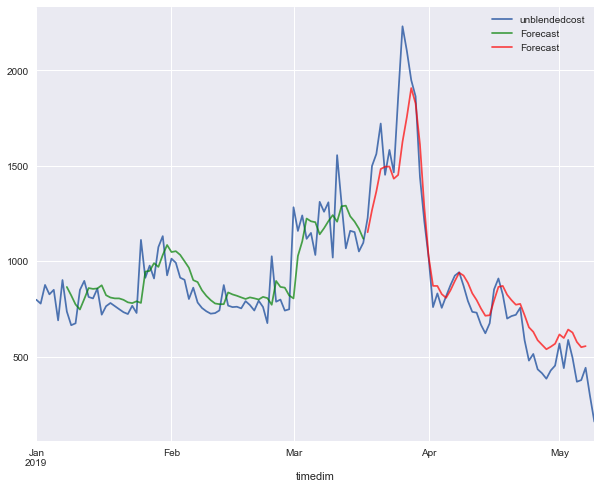

[7, 32, 'relu', 0.001]
Epoch 00128: early stopping


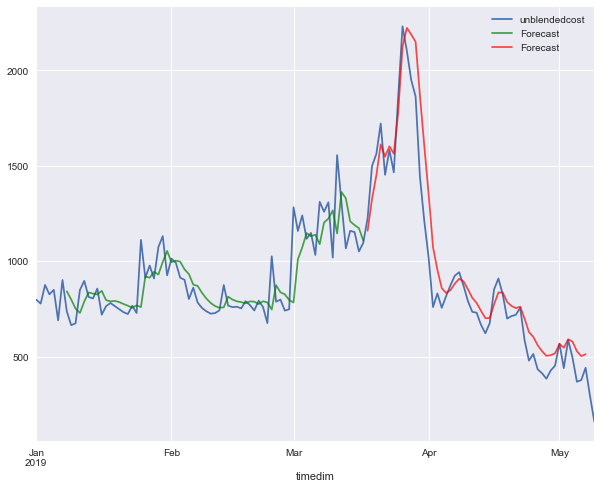

[7, 32, 'relu', 0.003]
Epoch 00062: early stopping


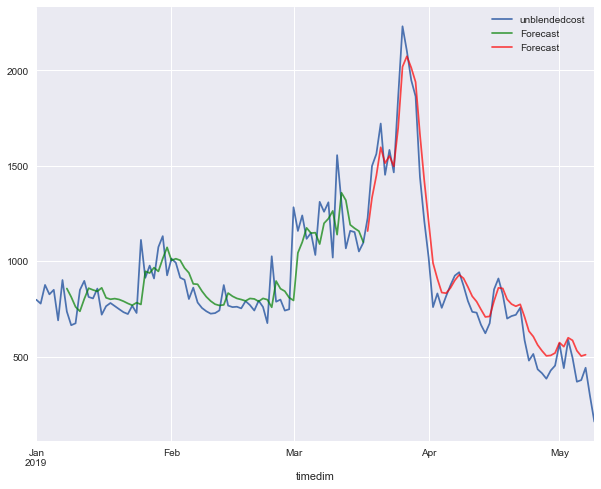

[7, 32, 'relu', 0.01]
Epoch 00854: early stopping


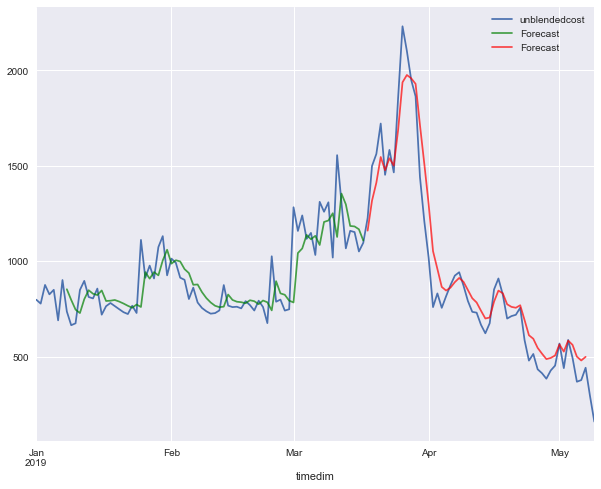

[7, 64, 'tanh', 0.0001]
Epoch 00348: early stopping


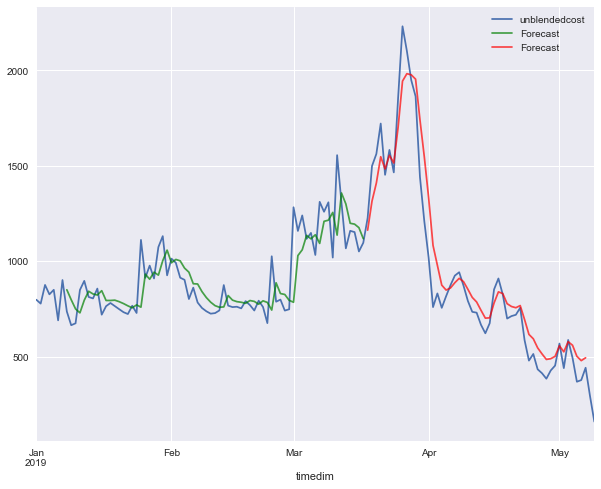

[7, 64, 'tanh', 0.0003]
Epoch 00128: early stopping


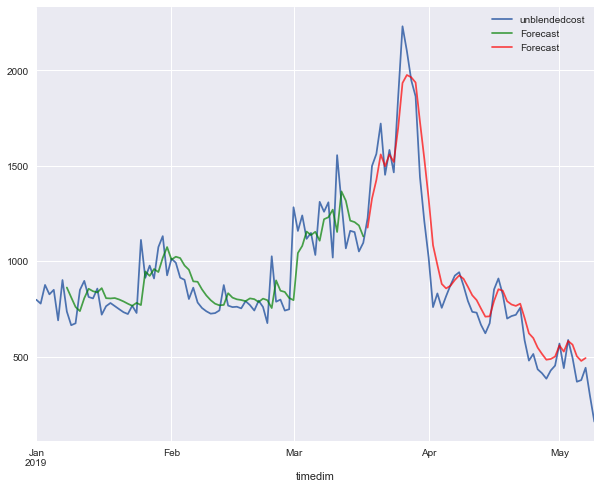

[7, 64, 'tanh', 0.001]
Epoch 00050: early stopping


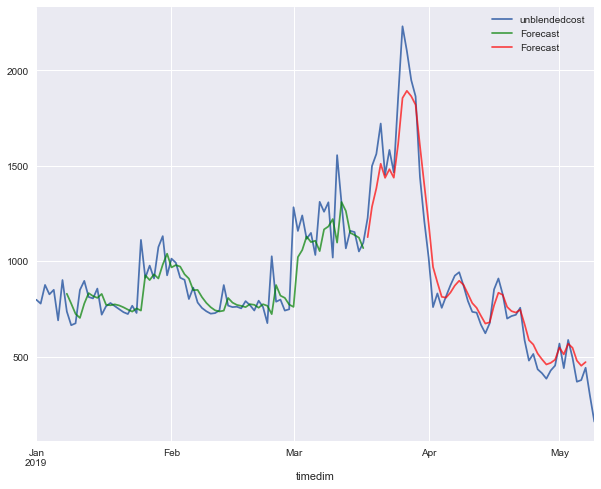

[7, 64, 'tanh', 0.003]
Epoch 00032: early stopping


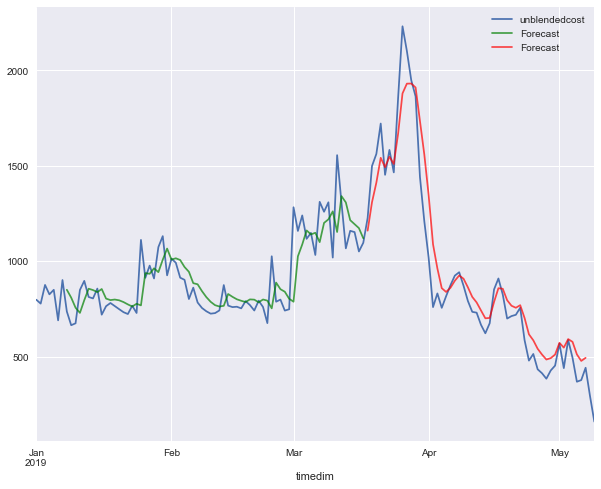

[7, 64, 'tanh', 0.01]


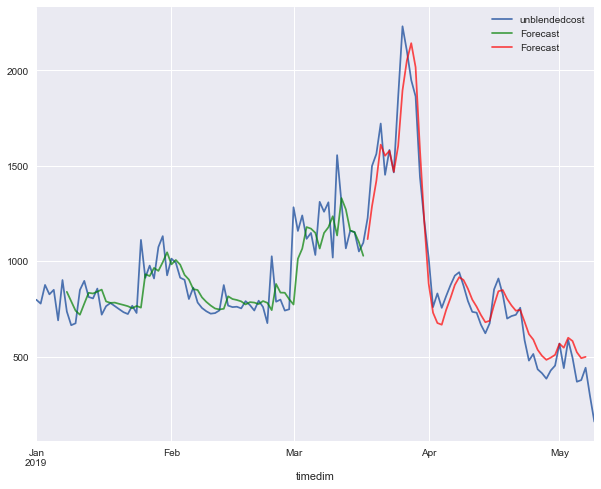

[7, 64, 'relu', 0.0001]
Epoch 00541: early stopping


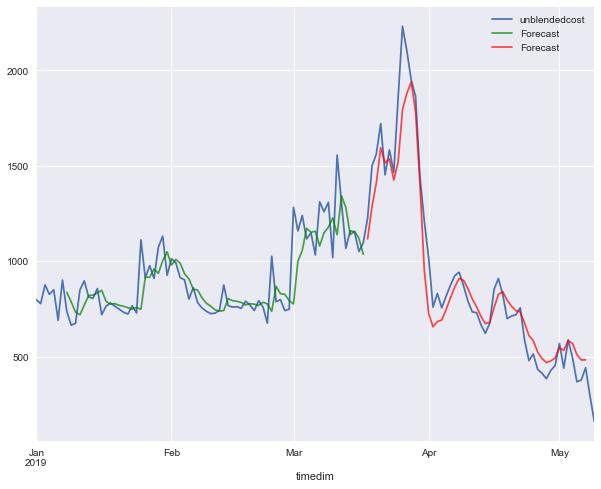

[7, 64, 'relu', 0.0003]
Epoch 00137: early stopping


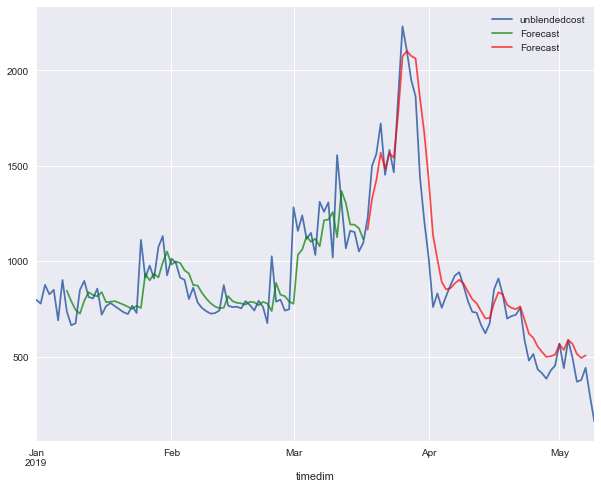

[7, 64, 'relu', 0.001]
Epoch 00075: early stopping


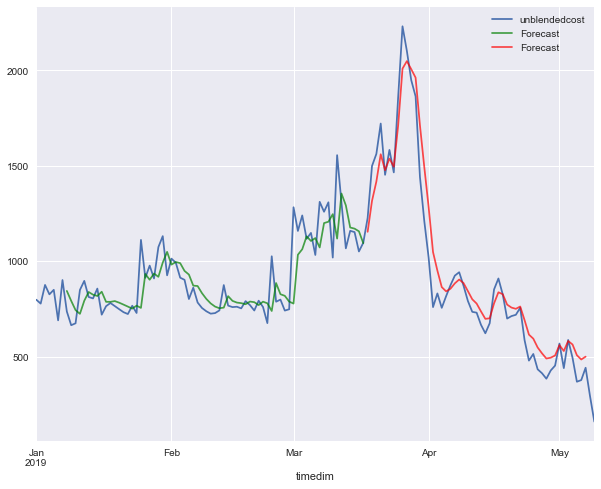

[7, 64, 'relu', 0.003]
Epoch 00080: early stopping


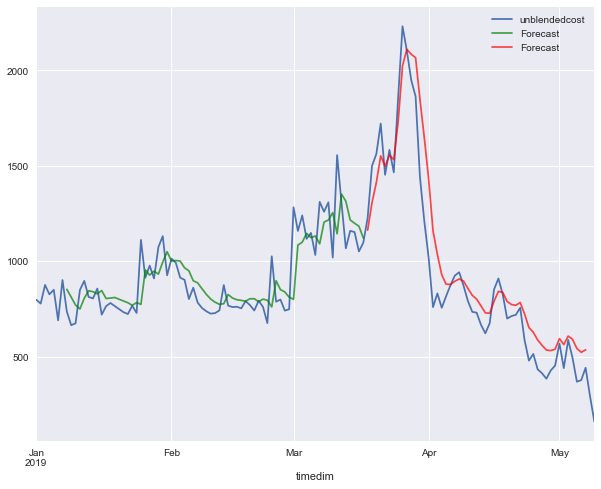

[7, 64, 'relu', 0.01]


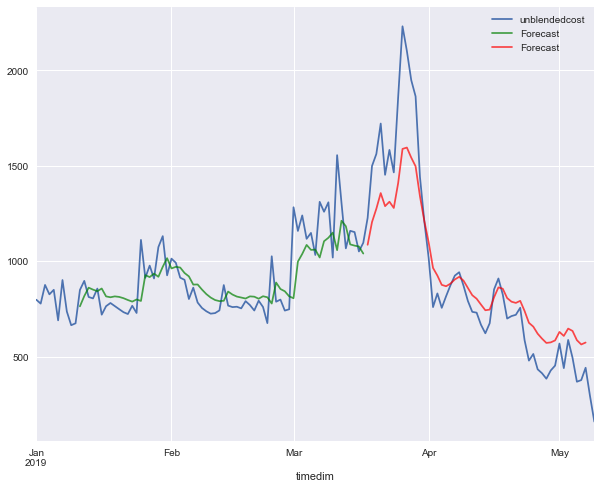

[10, 16, 'tanh', 0.0001]
Epoch 00721: early stopping


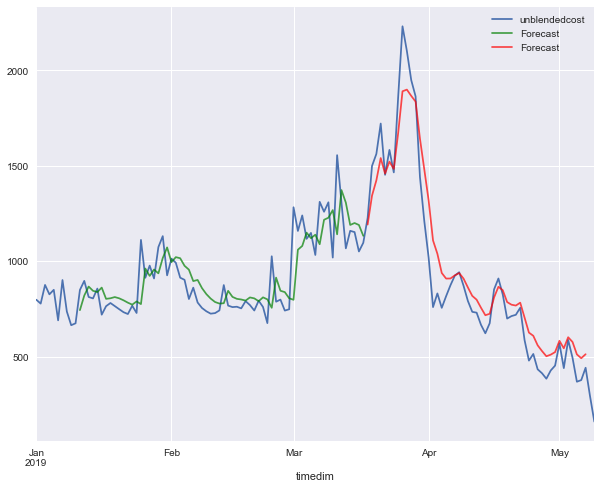

[10, 16, 'tanh', 0.0003]
Epoch 00243: early stopping


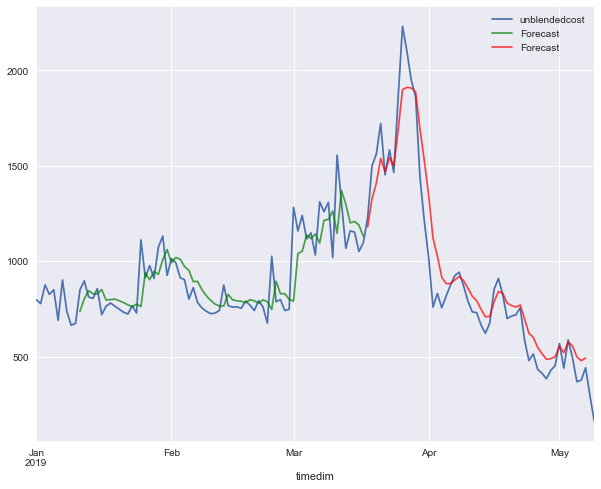

[10, 16, 'tanh', 0.001]
Epoch 00128: early stopping


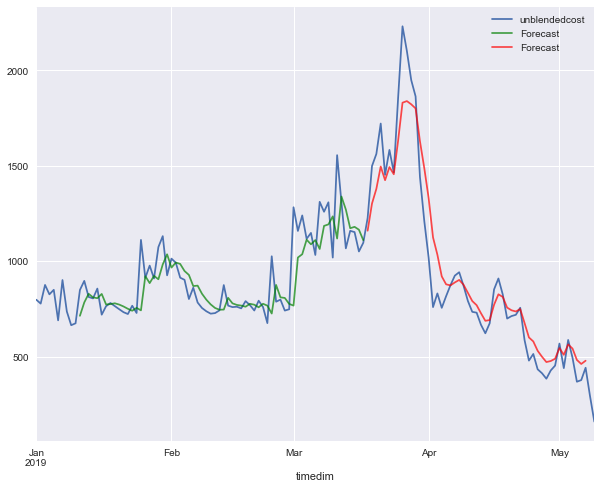

[10, 16, 'tanh', 0.003]
Epoch 00054: early stopping


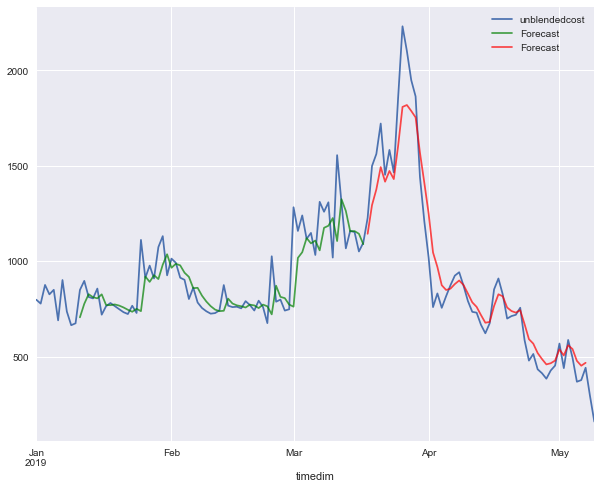

[10, 16, 'tanh', 0.01]


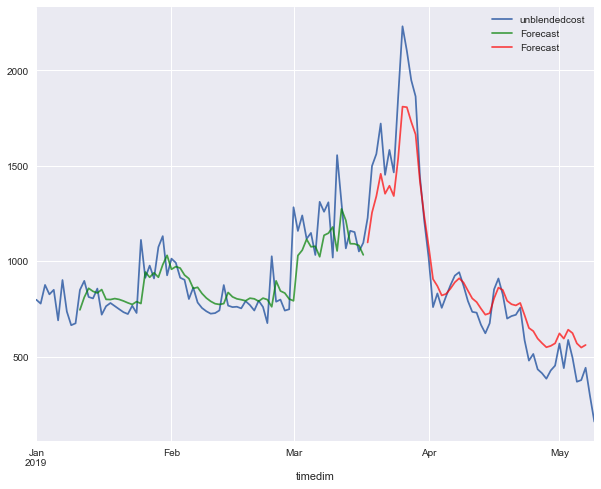

[10, 16, 'relu', 0.0001]


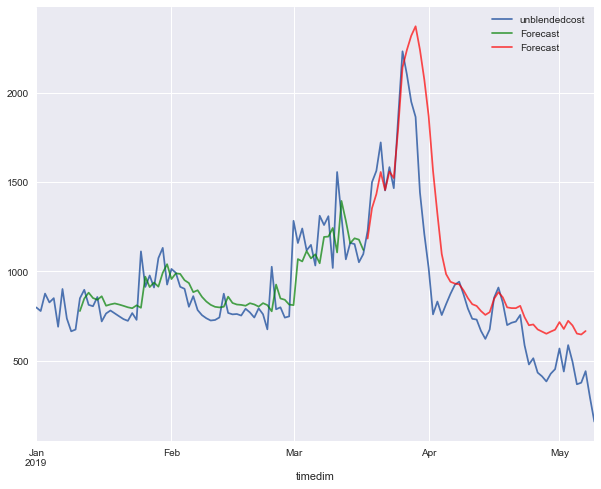

[10, 16, 'relu', 0.0003]
Epoch 00398: early stopping


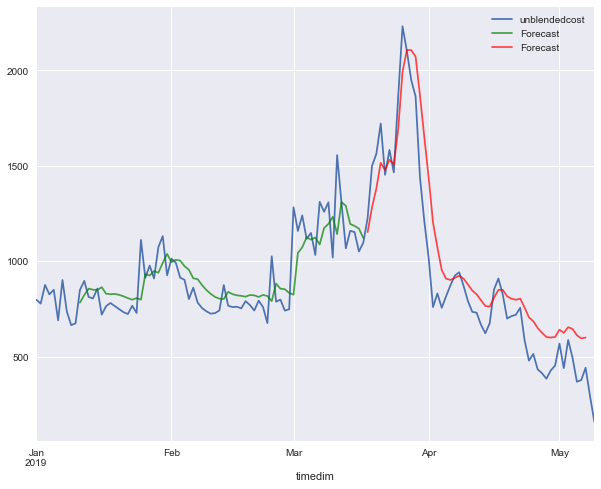

[10, 16, 'relu', 0.001]
Epoch 00158: early stopping


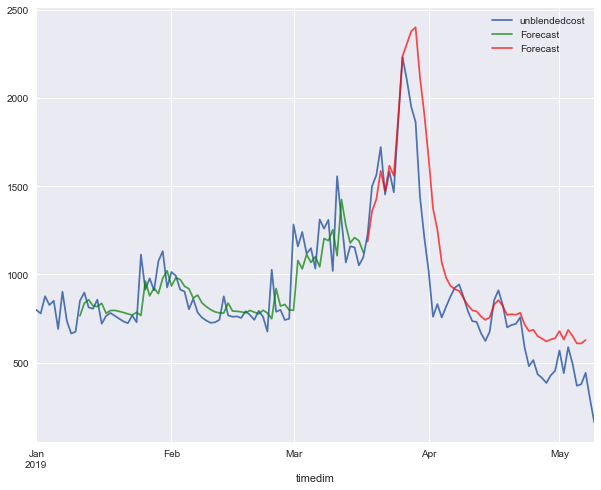

[10, 16, 'relu', 0.003]
Epoch 00066: early stopping


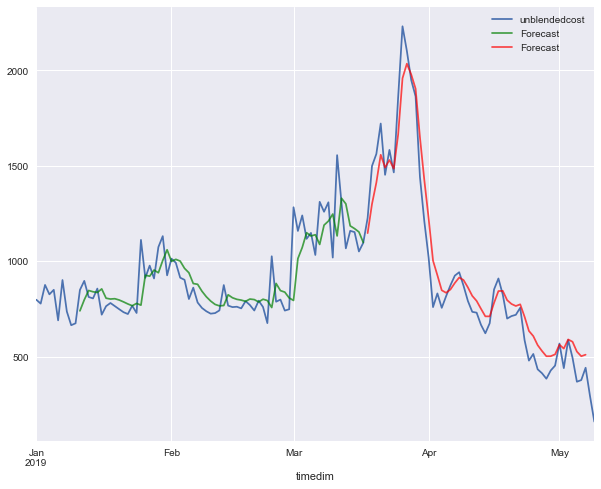

[10, 16, 'relu', 0.01]


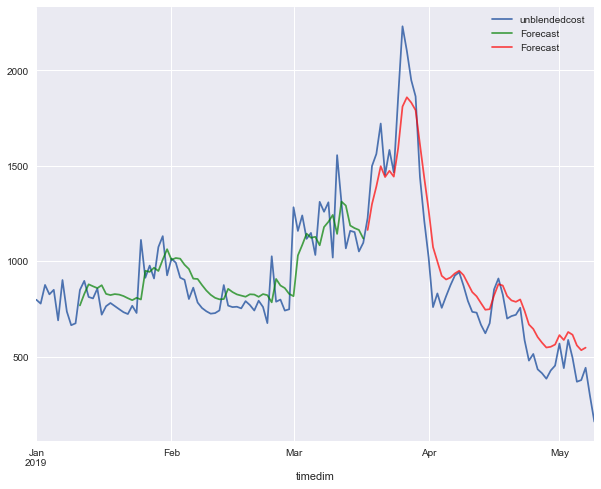

[10, 32, 'tanh', 0.0001]
Epoch 00542: early stopping


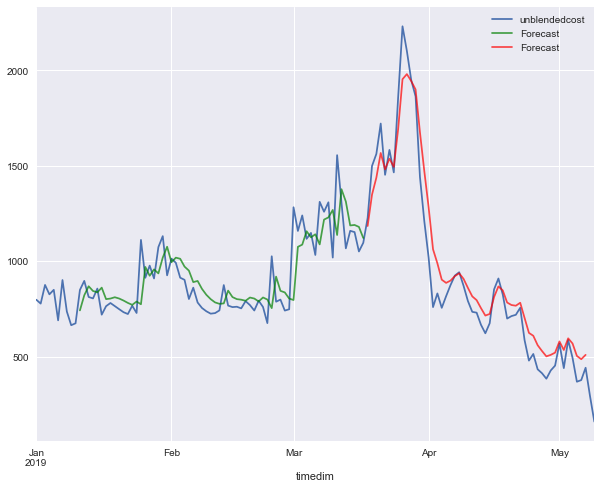

[10, 32, 'tanh', 0.0003]
Epoch 00212: early stopping


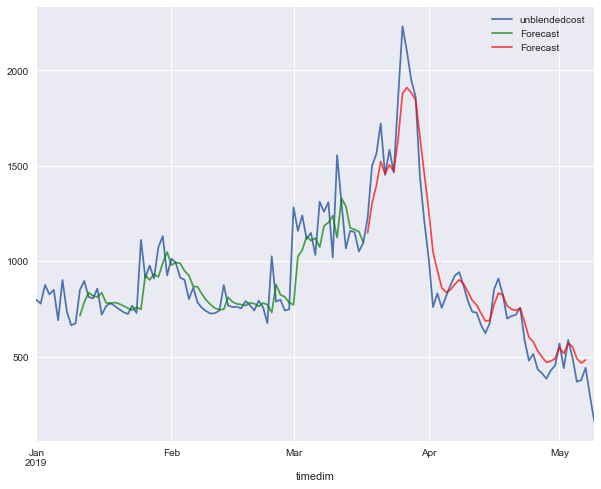

[10, 32, 'tanh', 0.001]
Epoch 00096: early stopping


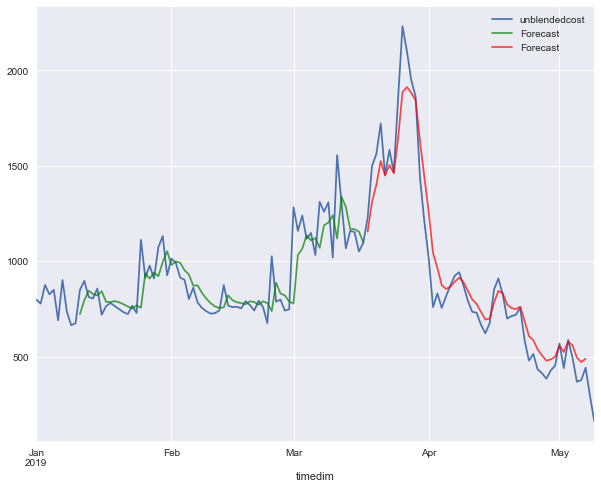

[10, 32, 'tanh', 0.003]
Epoch 00033: early stopping


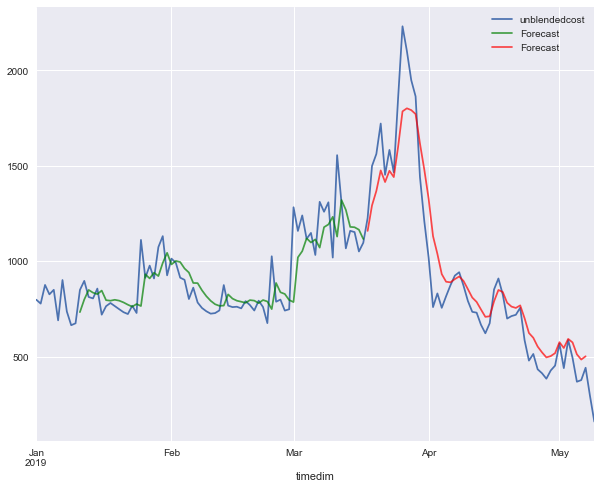

[10, 32, 'tanh', 0.01]


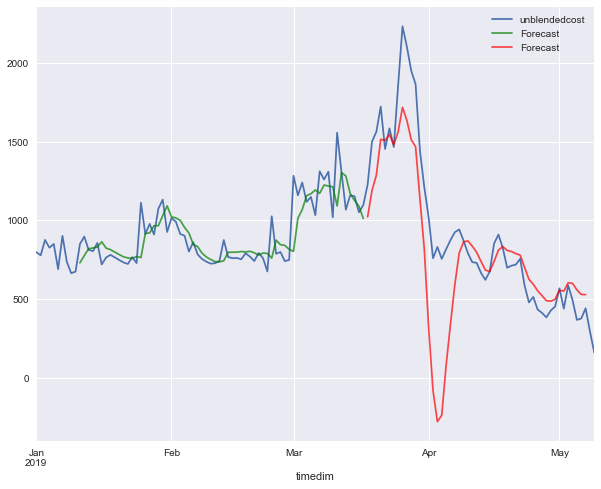

[10, 32, 'relu', 0.0001]
Epoch 00567: early stopping


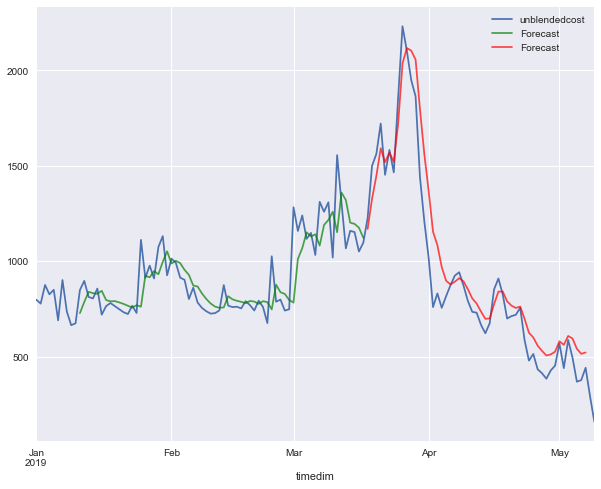

[10, 32, 'relu', 0.0003]
Epoch 00283: early stopping


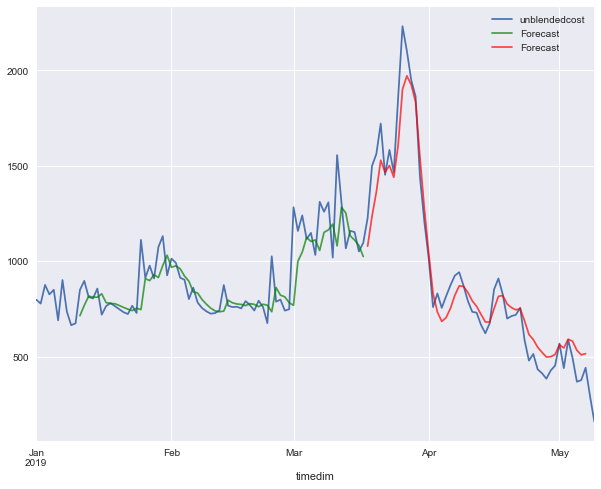

[10, 32, 'relu', 0.001]
Epoch 00075: early stopping


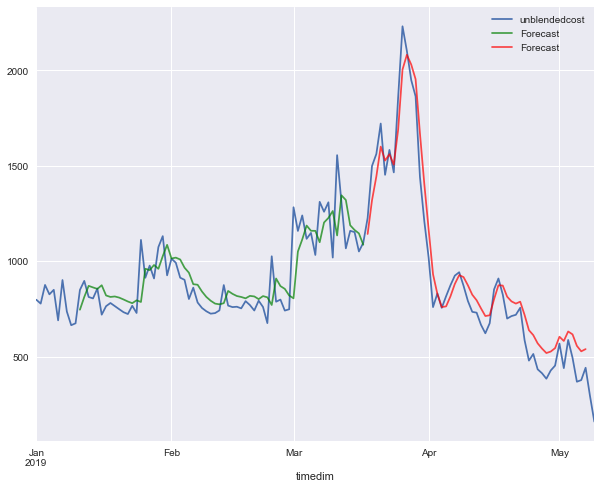

[10, 32, 'relu', 0.003]
Epoch 00074: early stopping


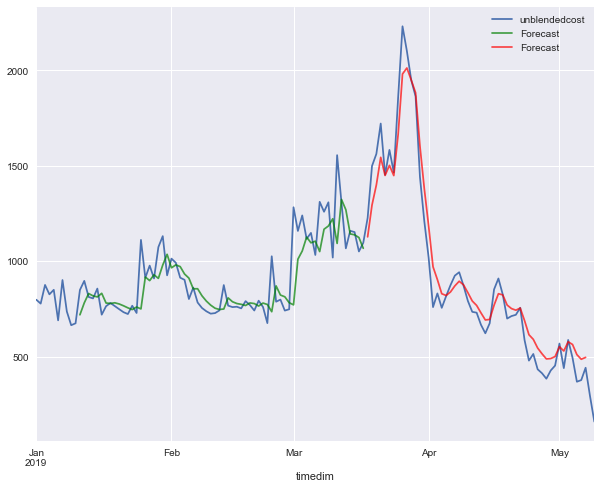

[10, 32, 'relu', 0.01]
Epoch 00863: early stopping


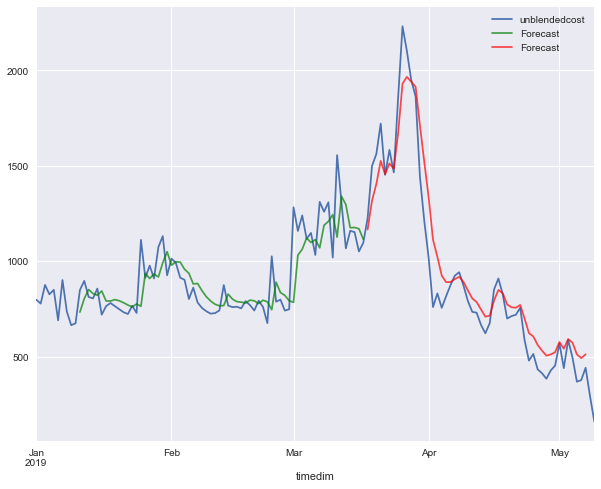

[10, 64, 'tanh', 0.0001]
Epoch 00365: early stopping


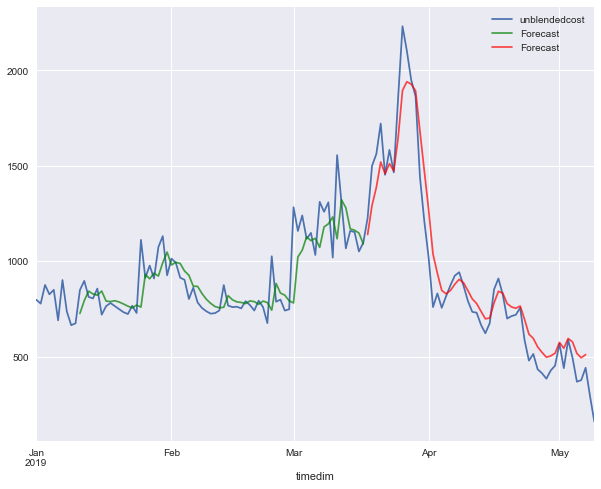

[10, 64, 'tanh', 0.0003]
Epoch 00155: early stopping


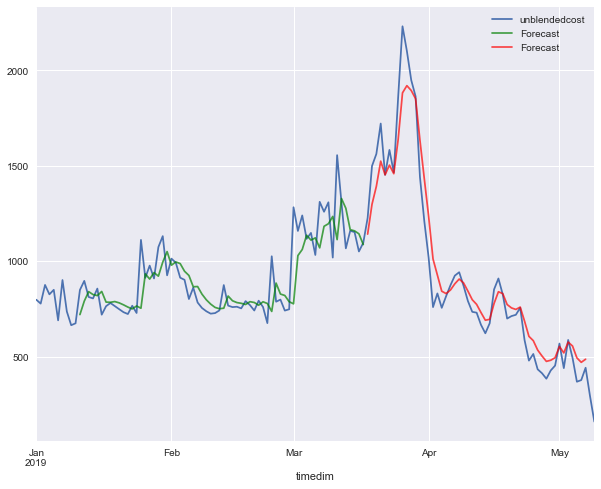

[10, 64, 'tanh', 0.001]
Epoch 00074: early stopping


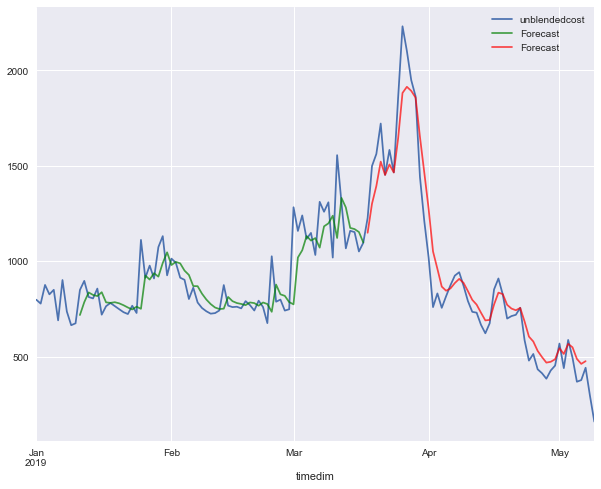

[10, 64, 'tanh', 0.003]
Epoch 00034: early stopping


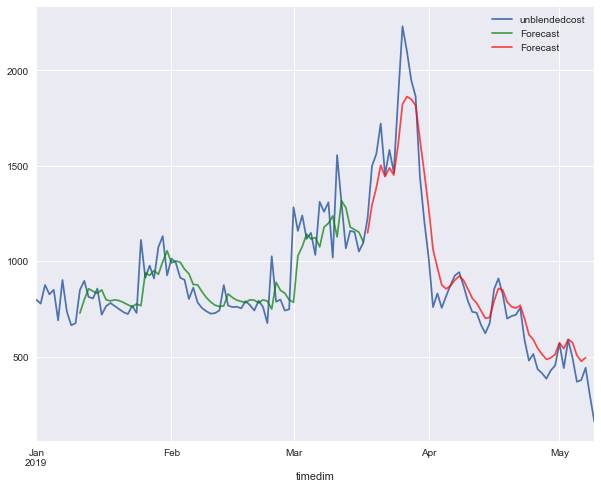

[10, 64, 'tanh', 0.01]


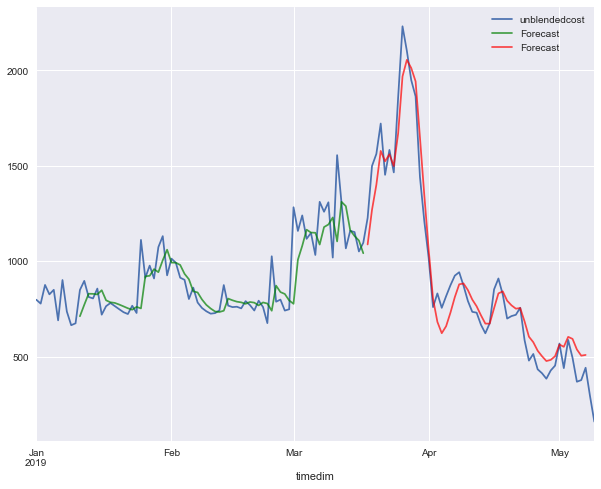

[10, 64, 'relu', 0.0001]
Epoch 00365: early stopping


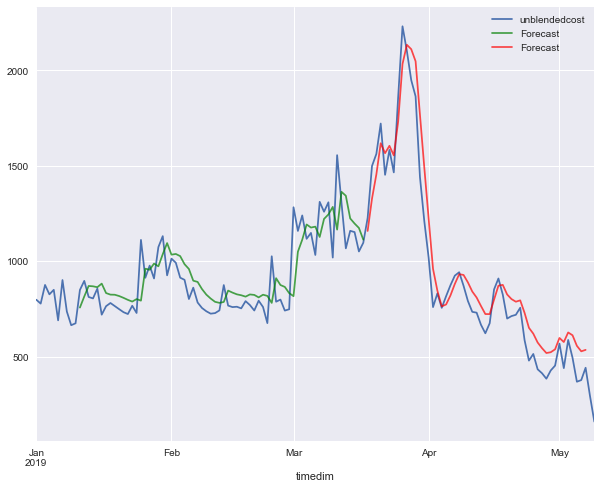

[10, 64, 'relu', 0.0003]
Epoch 00191: early stopping


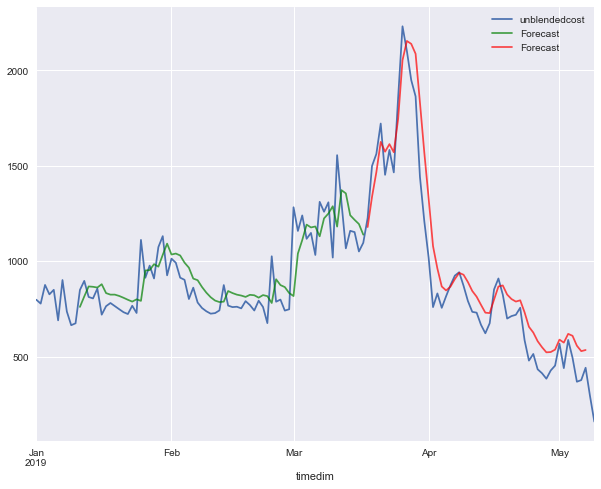

[10, 64, 'relu', 0.001]
Epoch 00070: early stopping


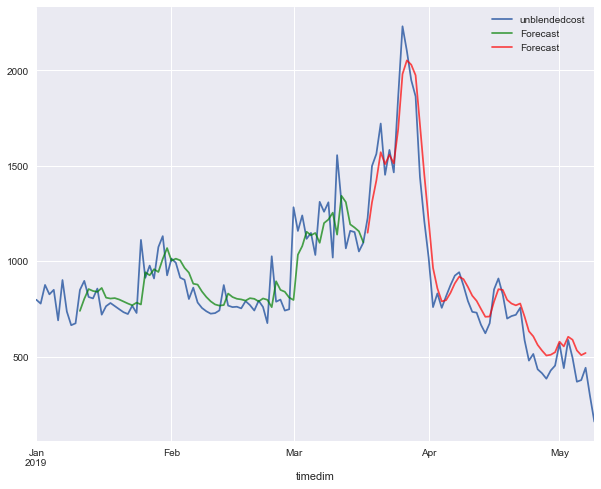

[10, 64, 'relu', 0.003]
Epoch 00097: early stopping


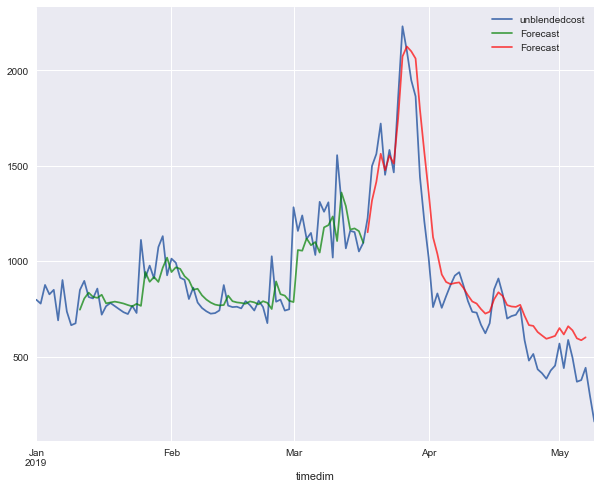

[10, 64, 'relu', 0.01]


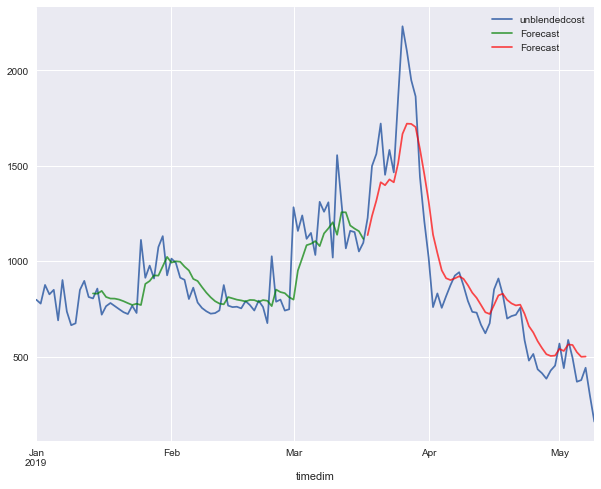

[13, 16, 'tanh', 0.0001]


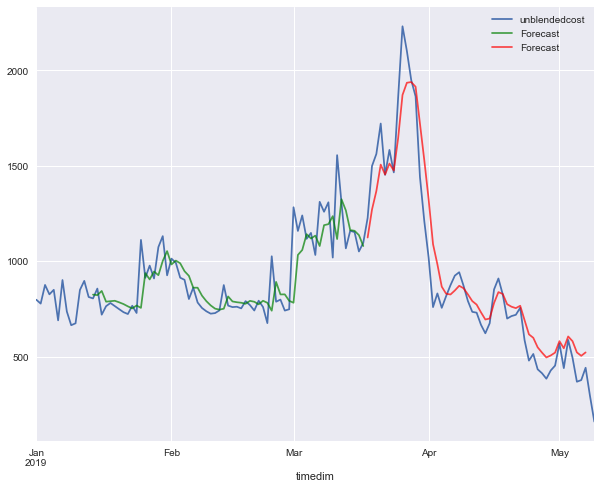

[13, 16, 'tanh', 0.0003]
Epoch 00484: early stopping


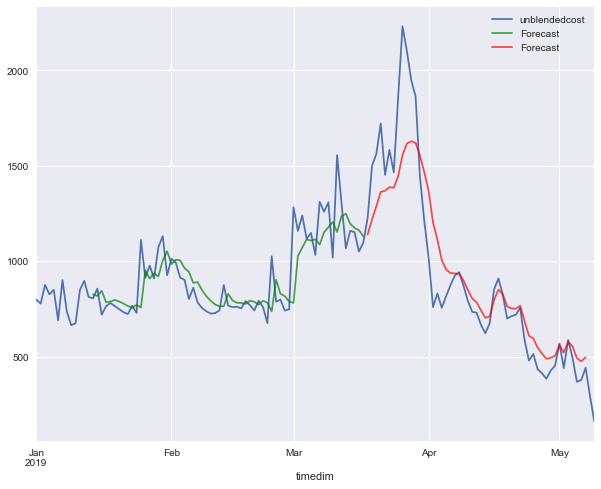

[13, 16, 'tanh', 0.001]
Epoch 00214: early stopping


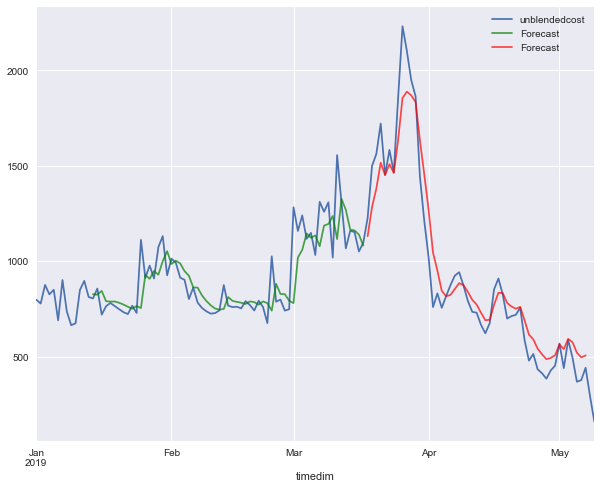

[13, 16, 'tanh', 0.003]
Epoch 00075: early stopping


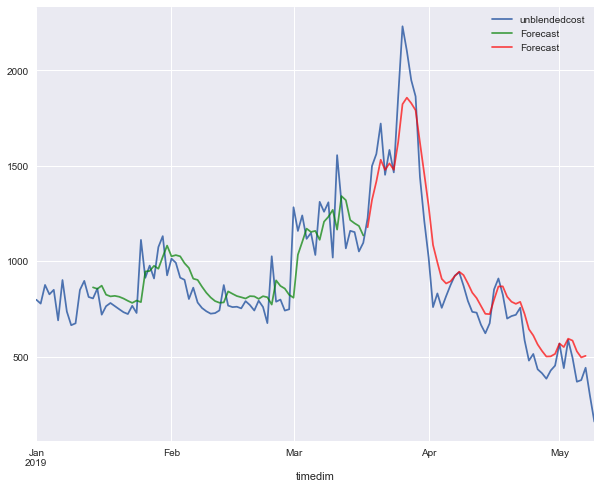

[13, 16, 'tanh', 0.01]


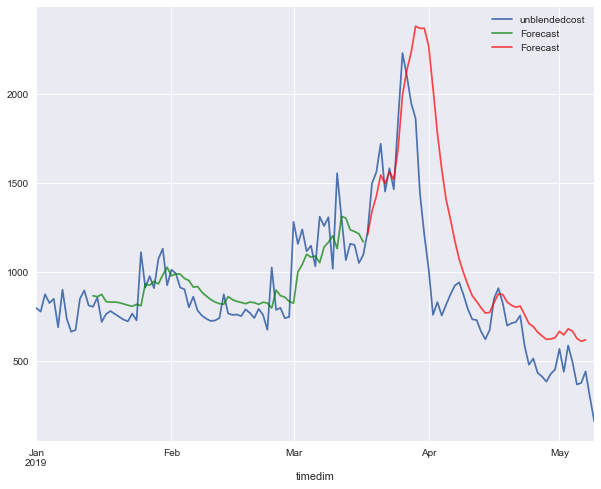

[13, 16, 'relu', 0.0001]


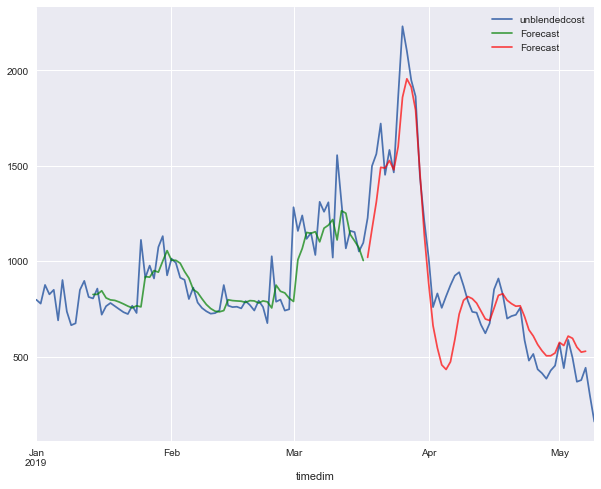

[13, 16, 'relu', 0.0003]
Epoch 00810: early stopping


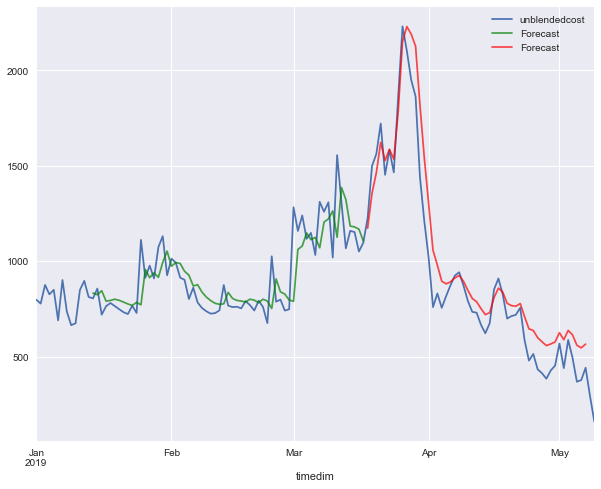

[13, 16, 'relu', 0.001]
Epoch 00190: early stopping


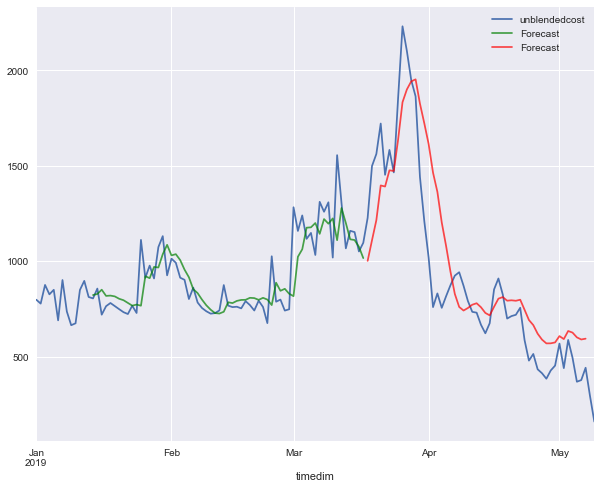

[13, 16, 'relu', 0.003]
Epoch 00203: early stopping


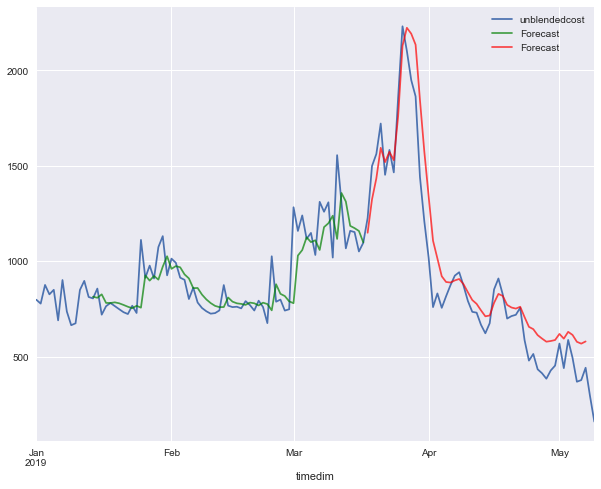

[13, 16, 'relu', 0.01]


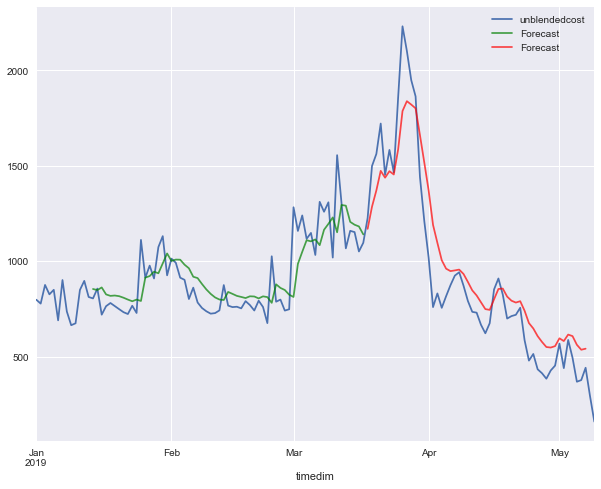

[13, 32, 'tanh', 0.0001]
Epoch 00920: early stopping


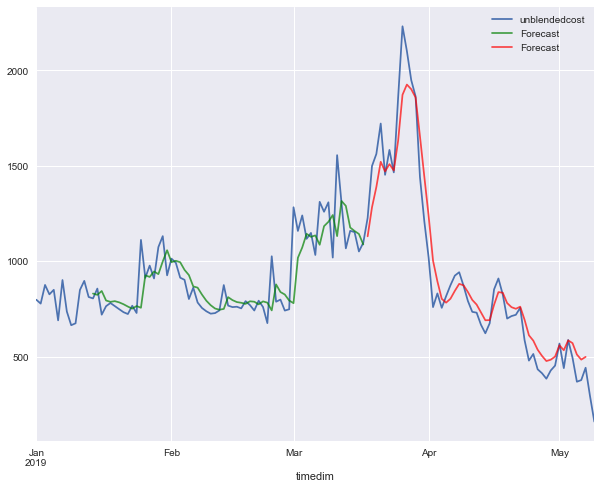

[13, 32, 'tanh', 0.0003]
Epoch 00249: early stopping


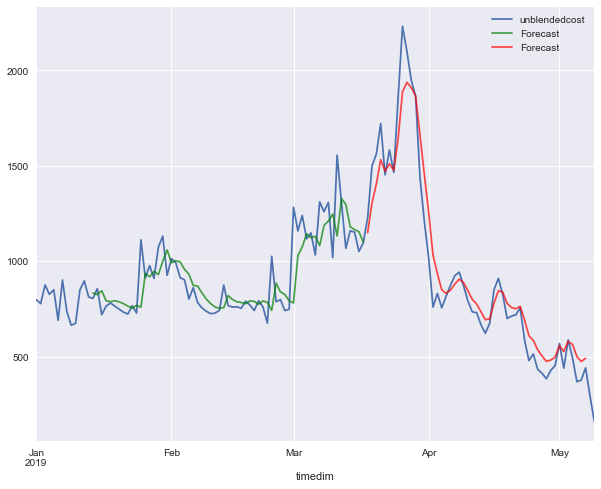

[13, 32, 'tanh', 0.001]
Epoch 00107: early stopping


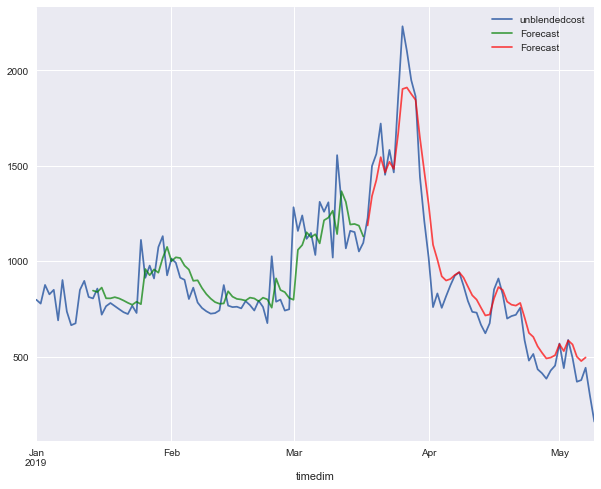

[13, 32, 'tanh', 0.003]
Epoch 00068: early stopping


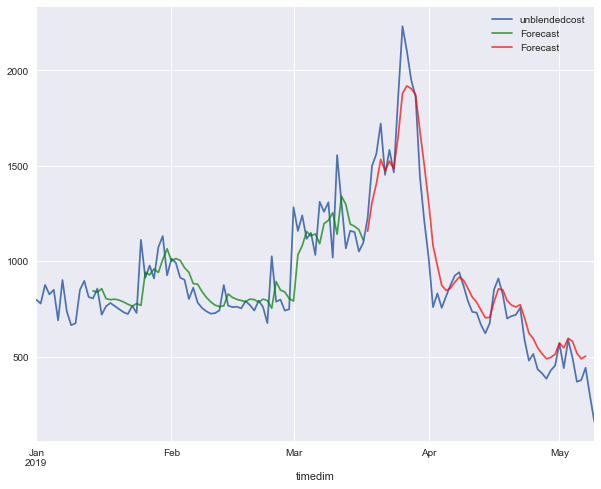

[13, 32, 'tanh', 0.01]


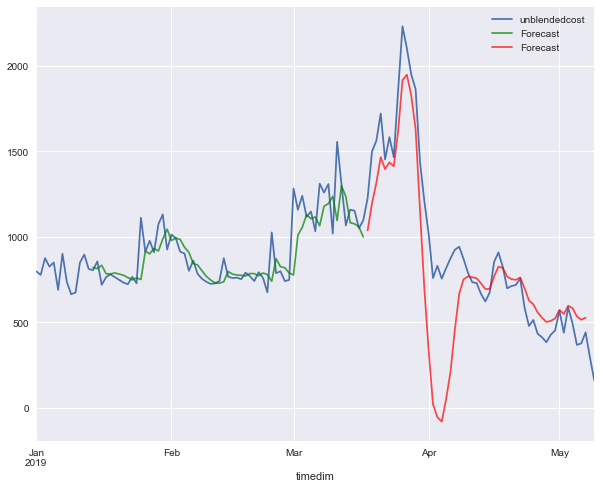

[13, 32, 'relu', 0.0001]
Epoch 00740: early stopping


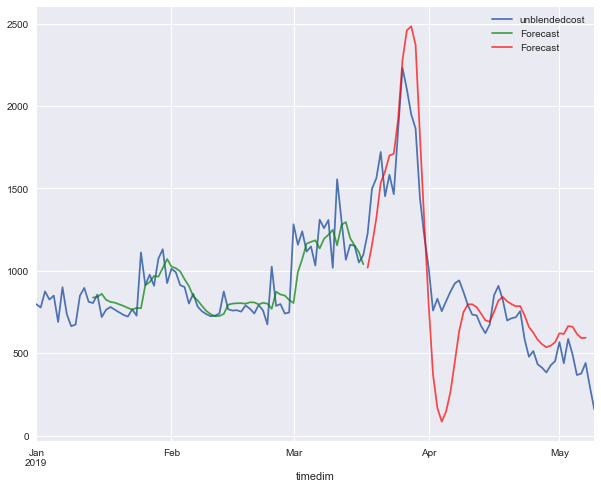

[13, 32, 'relu', 0.0003]
Epoch 00361: early stopping


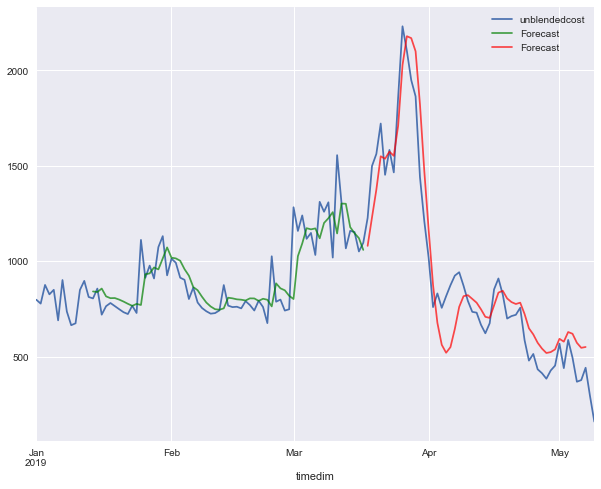

[13, 32, 'relu', 0.001]
Epoch 00295: early stopping


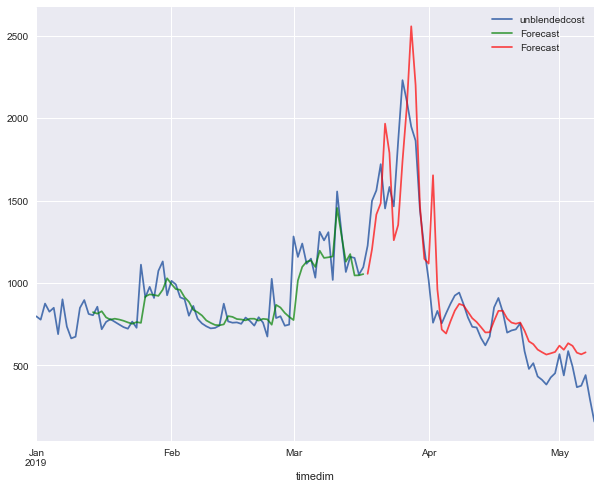

[13, 32, 'relu', 0.003]
Epoch 00087: early stopping


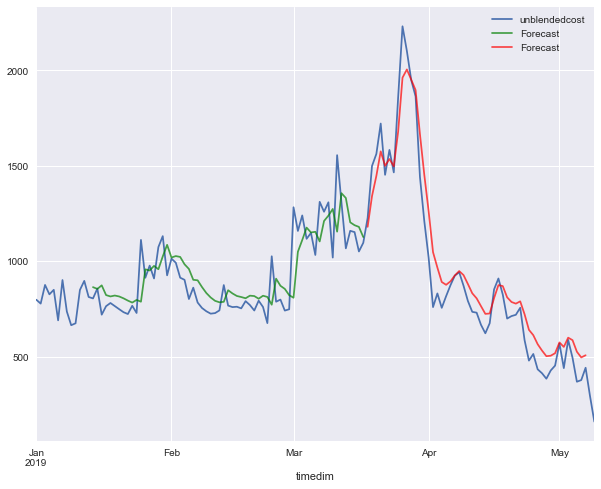

[13, 32, 'relu', 0.01]


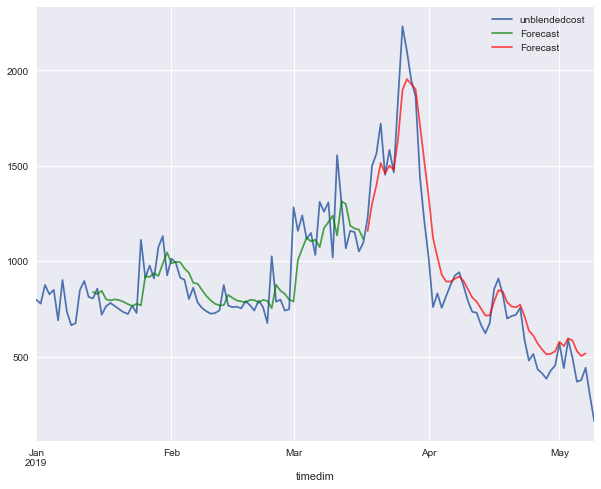

[13, 64, 'tanh', 0.0001]
Epoch 00554: early stopping


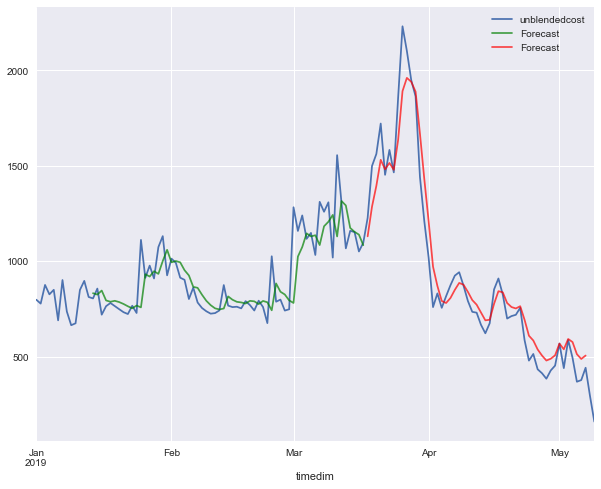

[13, 64, 'tanh', 0.0003]
Epoch 00191: early stopping


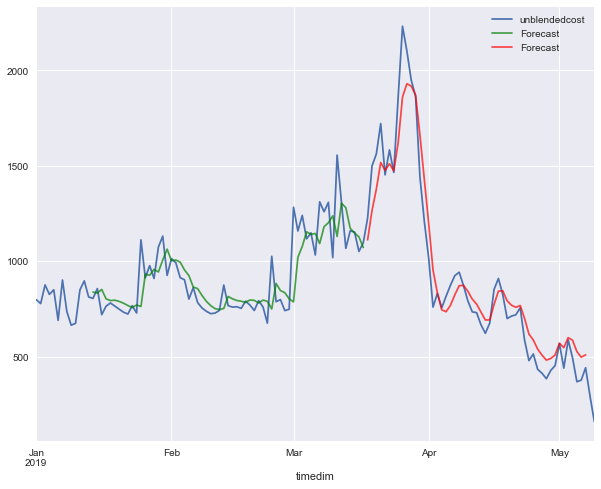

[13, 64, 'tanh', 0.001]
Epoch 00100: early stopping


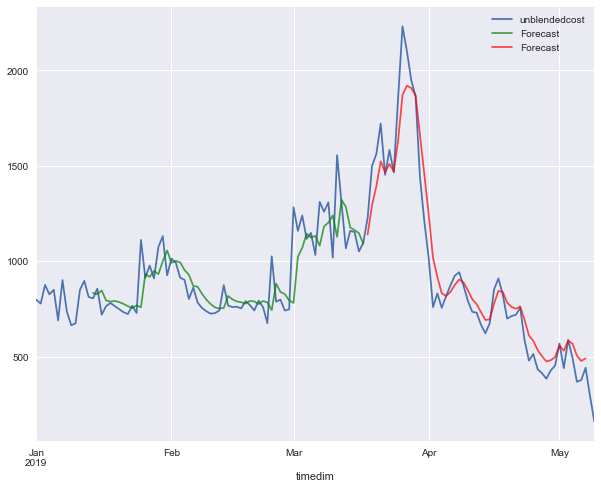

[13, 64, 'tanh', 0.003]
Epoch 00057: early stopping


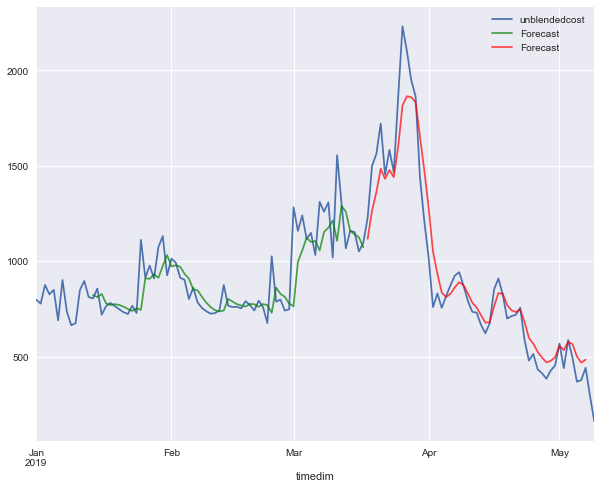

[13, 64, 'tanh', 0.01]


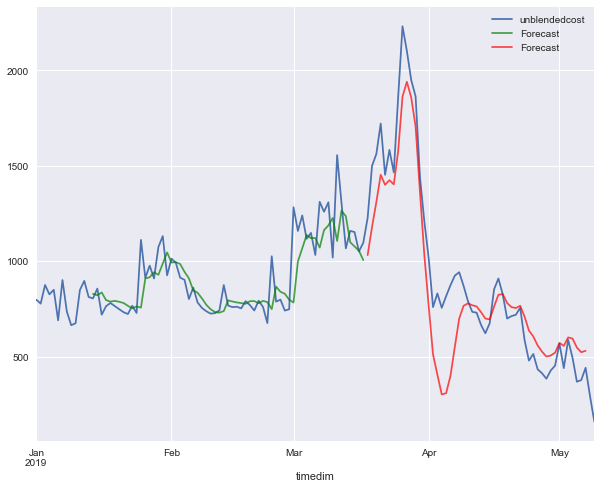

[13, 64, 'relu', 0.0001]
Epoch 00480: early stopping


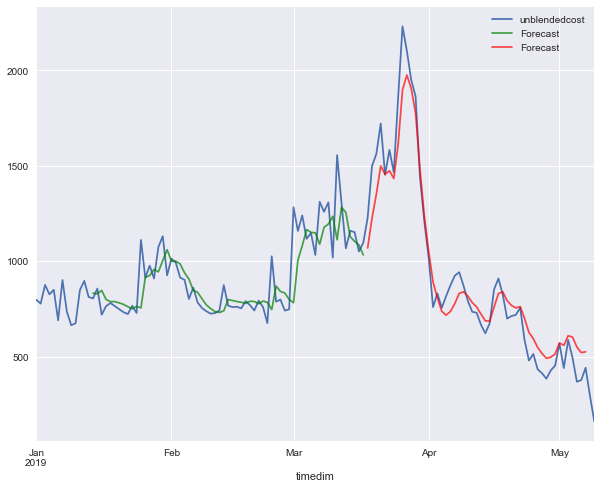

[13, 64, 'relu', 0.0003]
Epoch 00224: early stopping


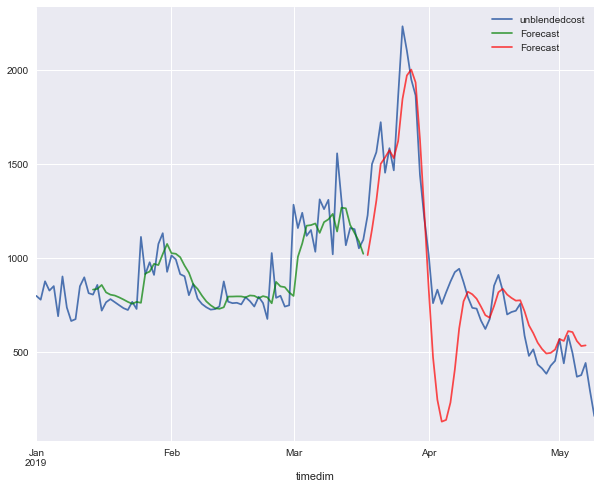

[13, 64, 'relu', 0.001]
Epoch 00094: early stopping


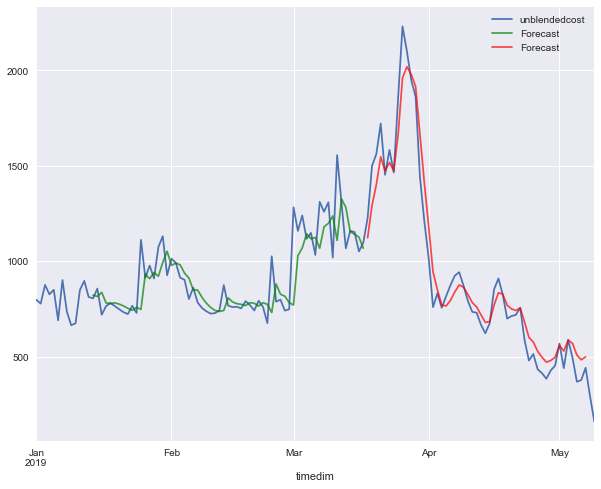

[13, 64, 'relu', 0.003]
Epoch 00051: early stopping


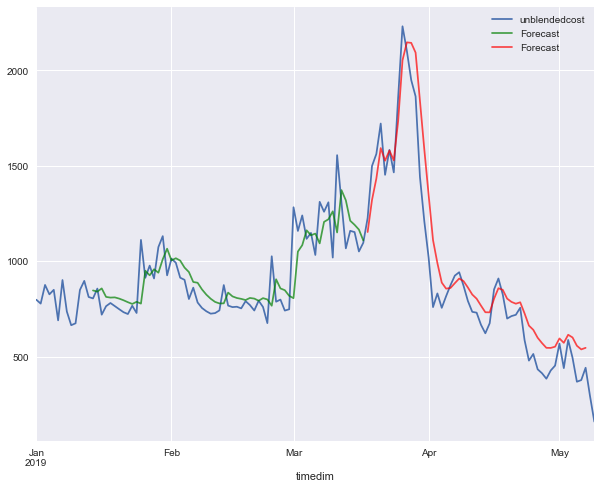

[13, 64, 'relu', 0.01]


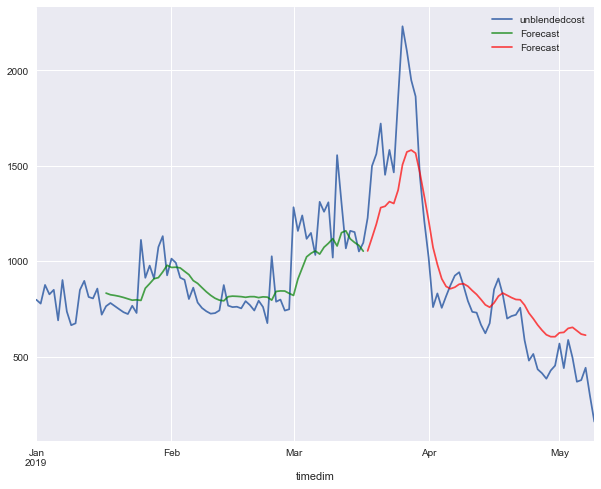

[16, 16, 'tanh', 0.0001]


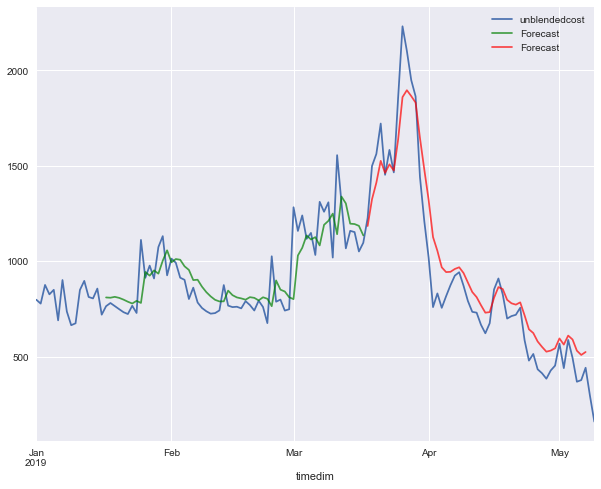

[16, 16, 'tanh', 0.0003]
Epoch 00401: early stopping


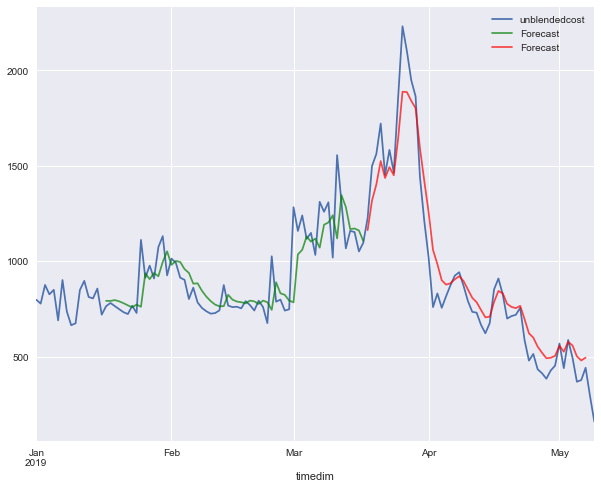

[16, 16, 'tanh', 0.001]
Epoch 00190: early stopping


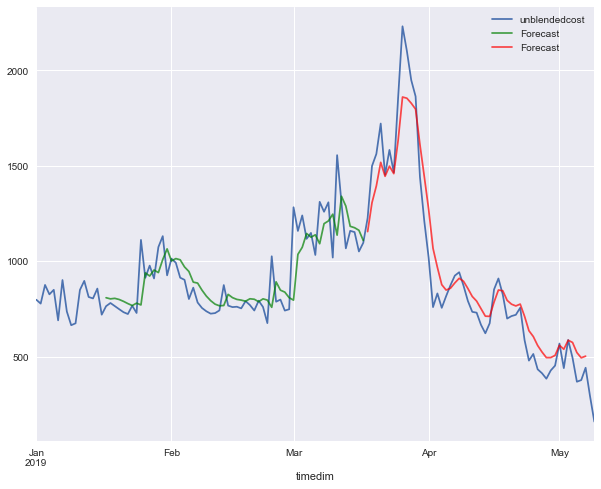

[16, 16, 'tanh', 0.003]
Epoch 00105: early stopping


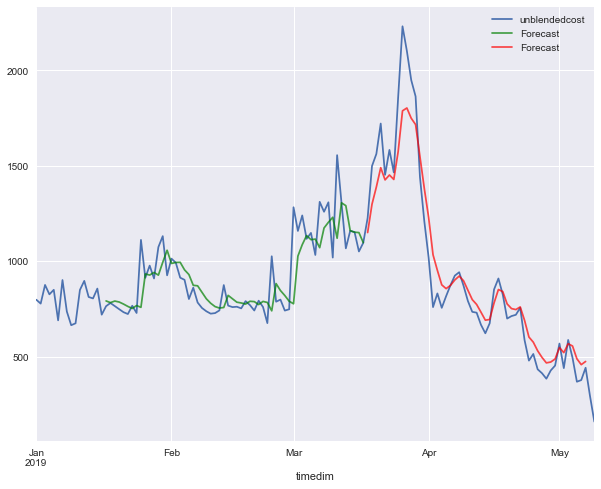

[16, 16, 'tanh', 0.01]


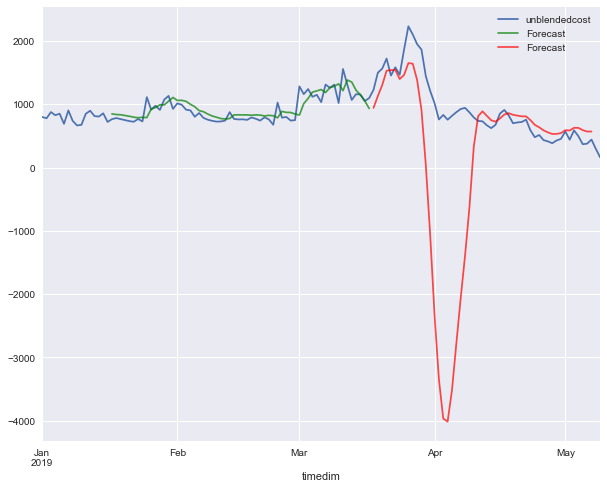

[16, 16, 'relu', 0.0001]
Epoch 00744: early stopping


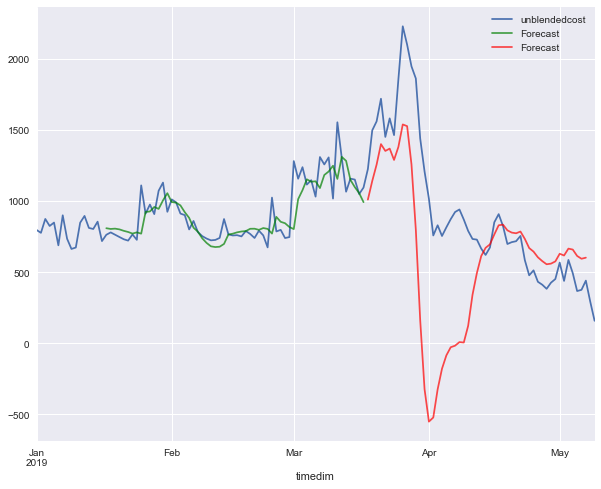

[16, 16, 'relu', 0.0003]
Epoch 00397: early stopping


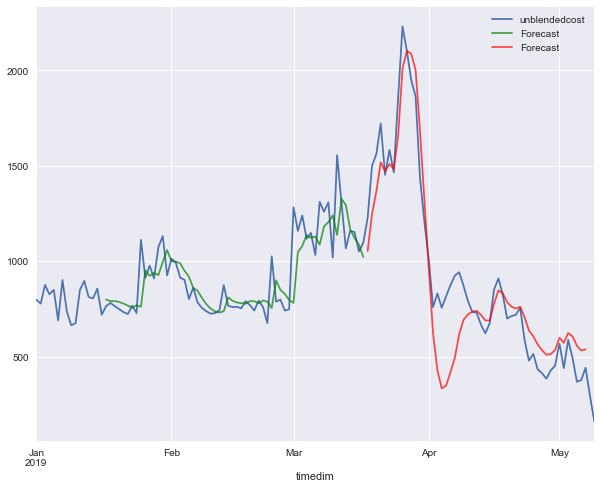

[16, 16, 'relu', 0.001]
Epoch 00114: early stopping


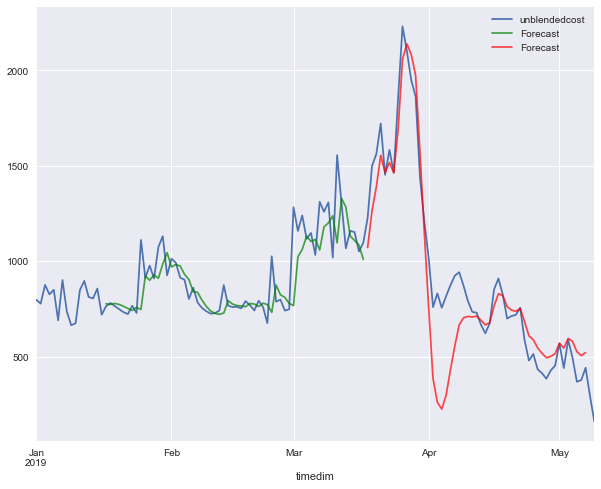

[16, 16, 'relu', 0.003]
Epoch 00040: early stopping


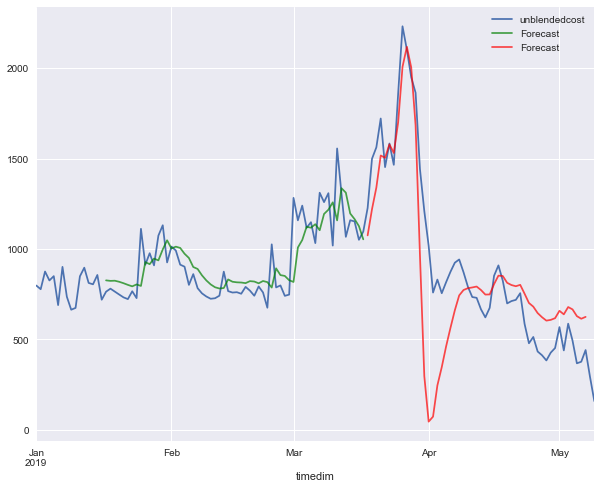

[16, 16, 'relu', 0.01]


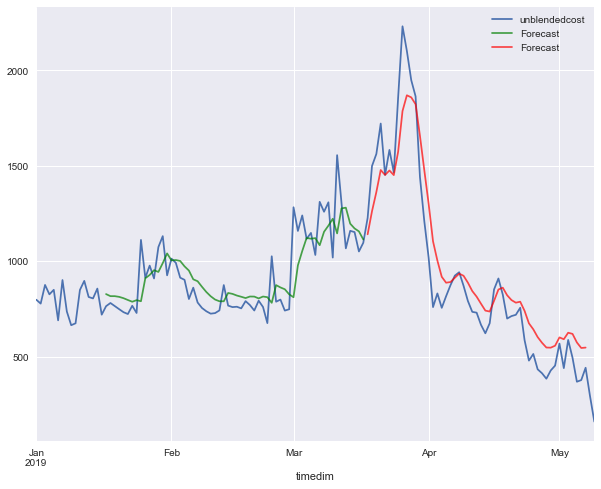

[16, 32, 'tanh', 0.0001]


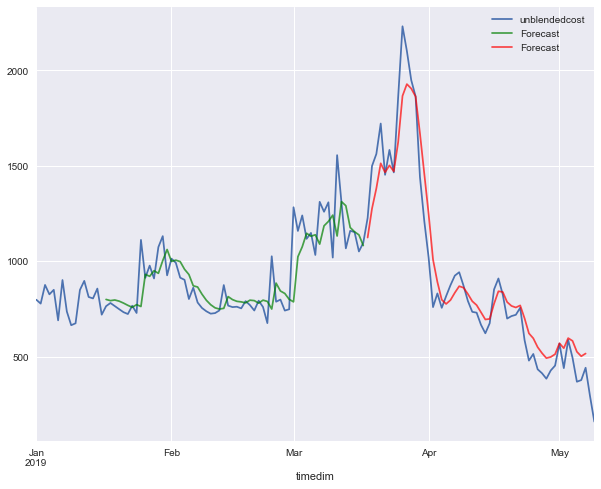

[16, 32, 'tanh', 0.0003]
Epoch 00358: early stopping


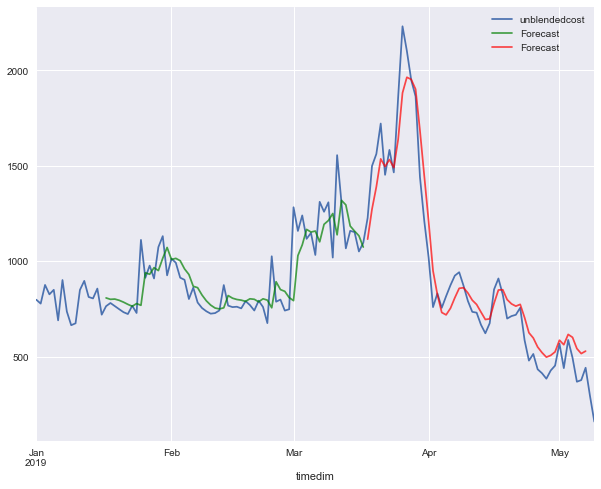

[16, 32, 'tanh', 0.001]
Epoch 00160: early stopping


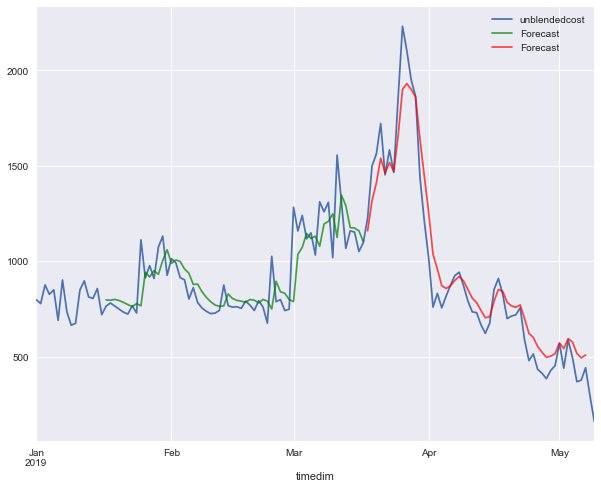

[16, 32, 'tanh', 0.003]
Epoch 00085: early stopping


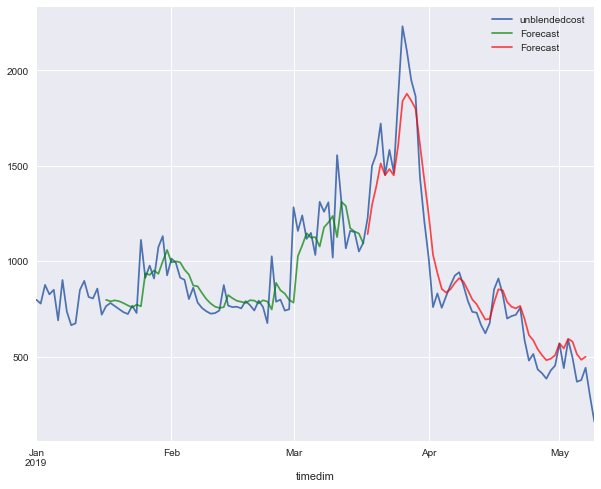

[16, 32, 'tanh', 0.01]


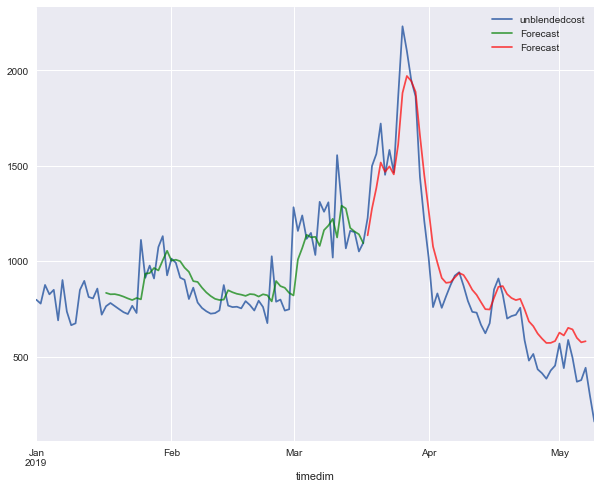

[16, 32, 'relu', 0.0001]
Epoch 00567: early stopping


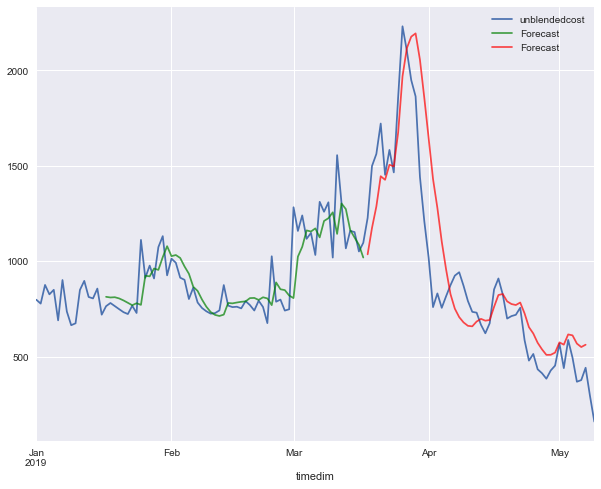

[16, 32, 'relu', 0.0003]
Epoch 00330: early stopping


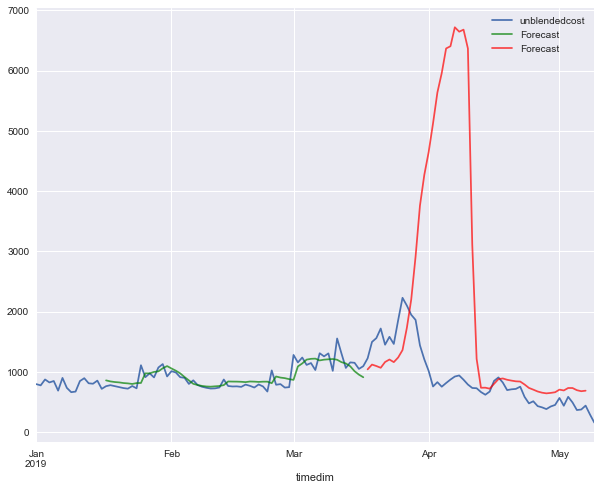

[16, 32, 'relu', 0.001]
Epoch 00108: early stopping


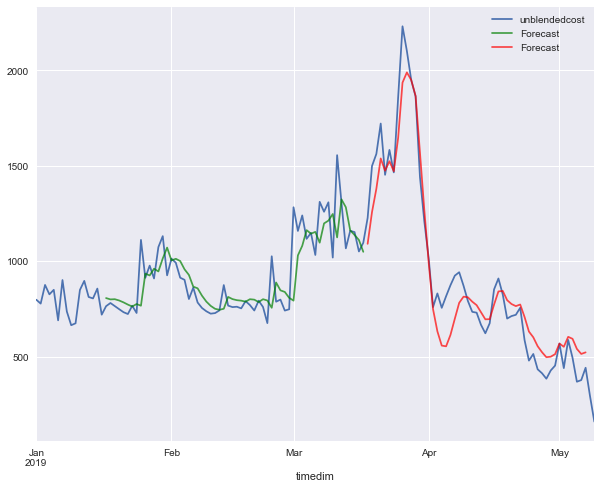

[16, 32, 'relu', 0.003]
Epoch 00053: early stopping


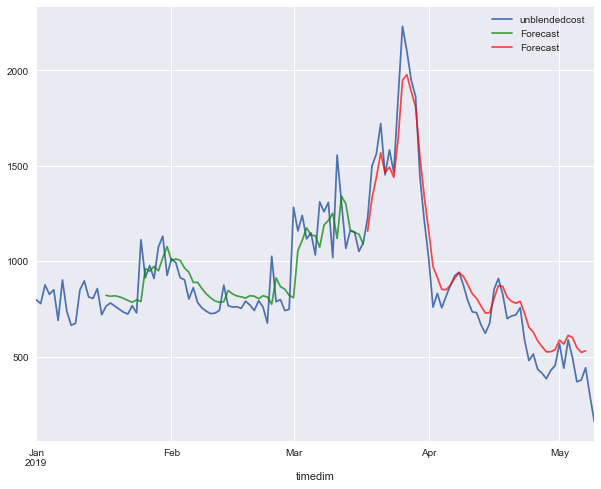

[16, 32, 'relu', 0.01]


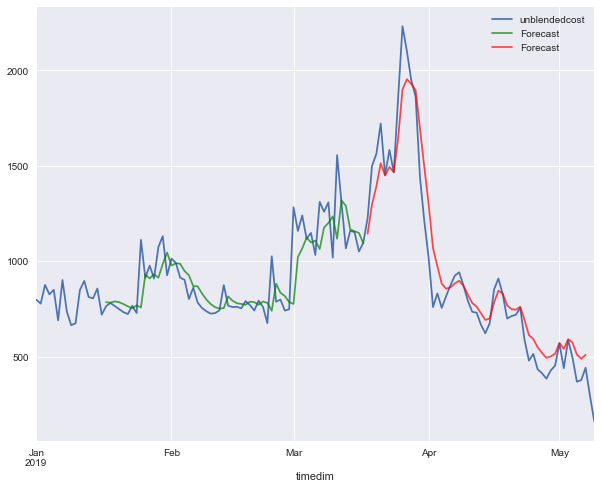

[16, 64, 'tanh', 0.0001]
Epoch 00541: early stopping


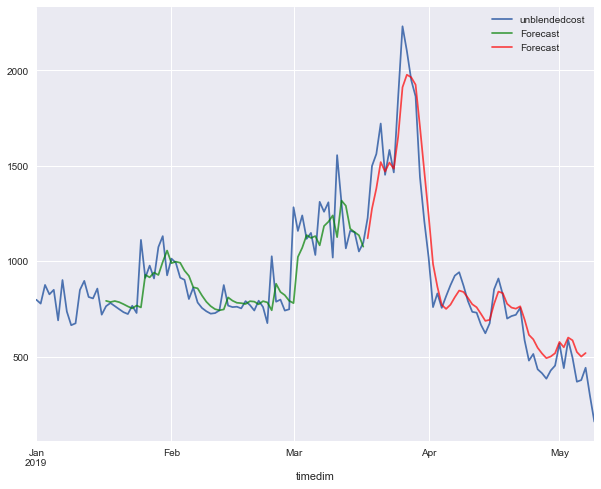

[16, 64, 'tanh', 0.0003]
Epoch 00216: early stopping


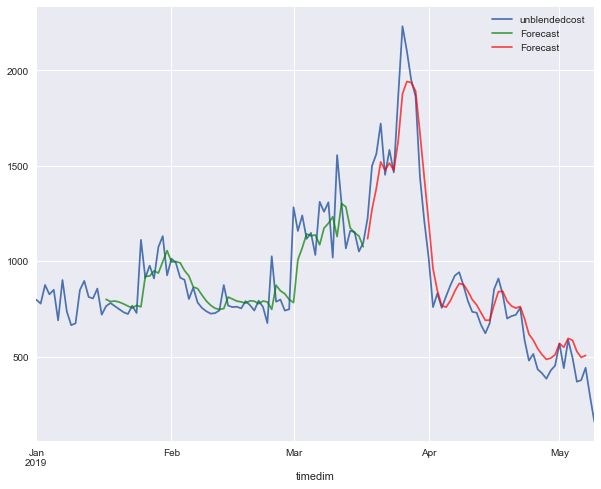

[16, 64, 'tanh', 0.001]
Epoch 00094: early stopping


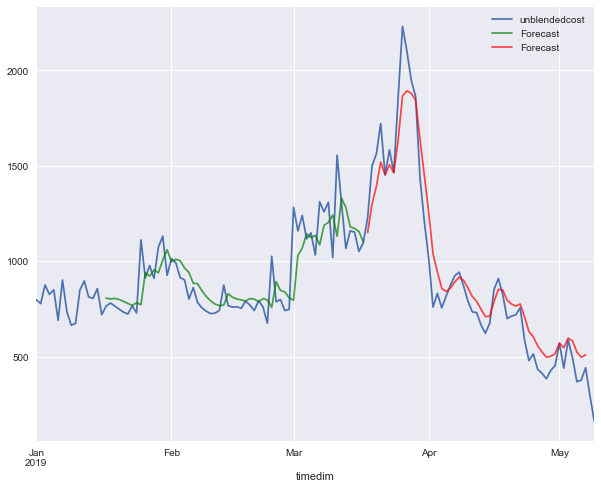

[16, 64, 'tanh', 0.003]
Epoch 00080: early stopping


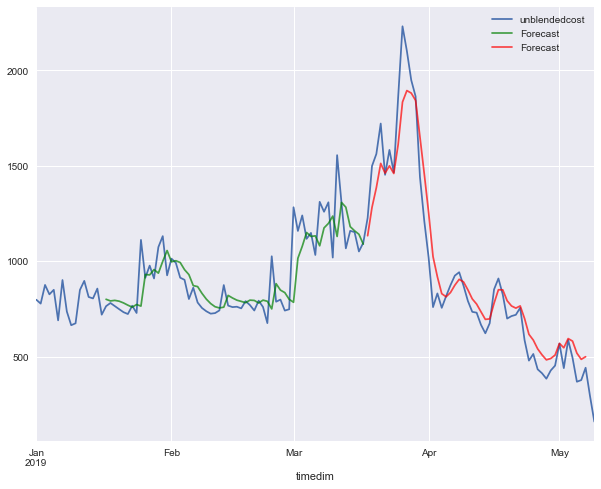

[16, 64, 'tanh', 0.01]


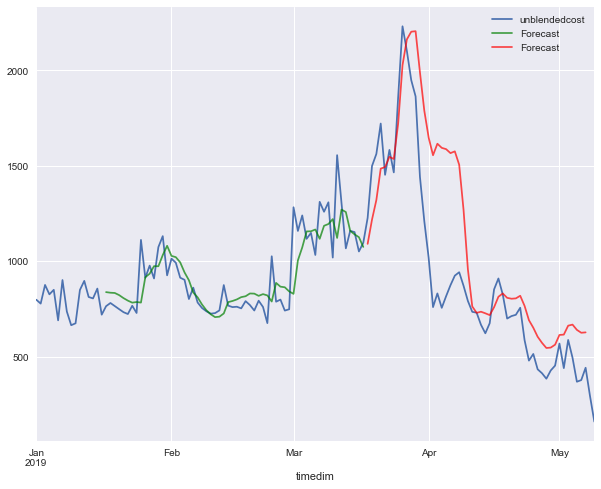

[16, 64, 'relu', 0.0001]
Epoch 00525: early stopping


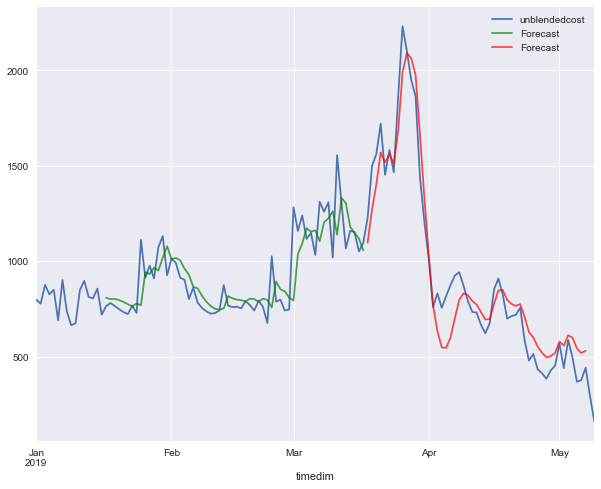

[16, 64, 'relu', 0.0003]
Epoch 00212: early stopping


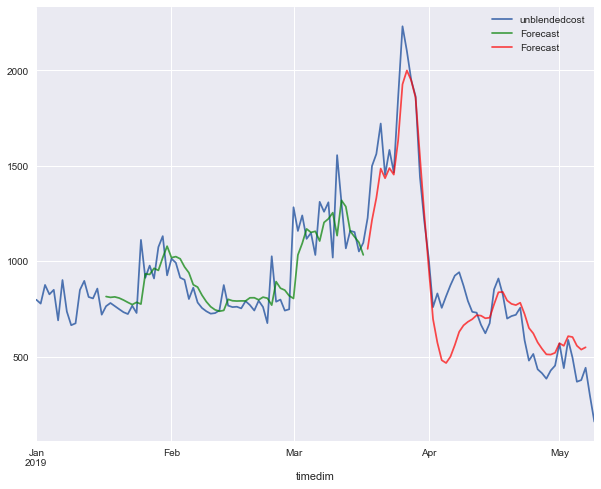

[16, 64, 'relu', 0.001]
Epoch 00093: early stopping


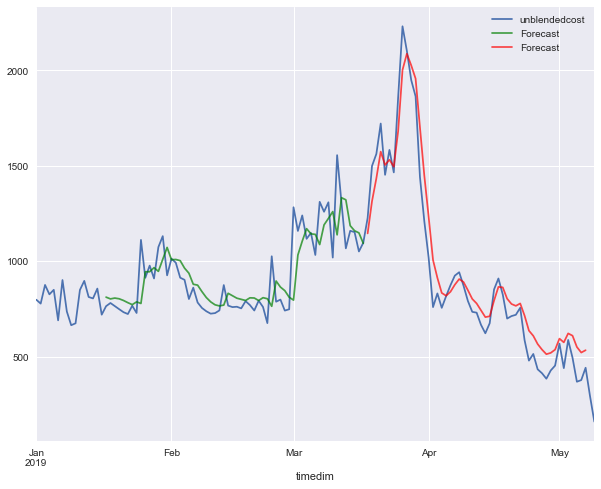

[16, 64, 'relu', 0.003]
Epoch 00020: early stopping


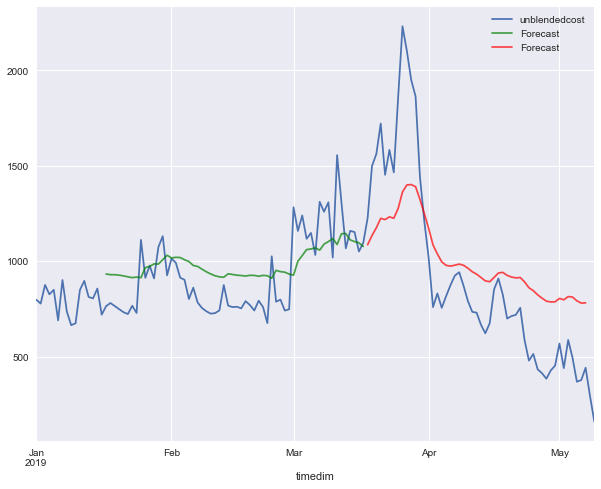

[16, 64, 'relu', 0.01]


In [60]:
for params in parameter_combination:
    try:
        model,X_train,Y_train=model_train_param(params)
        temp=model_overfitting_check(model,params[0],X_train,Y_train)
        print(list(params))
        print("====================================================")
        grid_search_results.loc[len(grid_search_results),:]=(list(params)+temp)
    except:
        continue

In [136]:
grid_search_results.sort_values(by='mse_in').head(10)

n_step unit activ      lr  R_2_in      mse_in   R_2_out       mse_out
78      13   32  relu 0.00300 0.70448 11978.14556   0.77949   54240.82865
107     16   32  relu 0.00100 0.62981 15366.77435 -22.92527 5885246.75365
68      13   16  relu 0.00300 0.60899 15848.34144   0.75753   59643.91768
76      13   32  relu 0.00030 0.60804 15886.95926   0.69394   75285.34673
87      13   64  relu 0.00100 0.60659 15945.60432   0.76796   57078.58811
45      10   32  relu 0.00010 0.59049 15955.22533   0.51711  118782.26462
77      13   32  relu 0.00100 0.60284 16097.58749   0.89884   24884.91540
29       7   64  relu 0.01000 0.58708 16306.30614   0.89790   25114.08948
115     16   64  relu 0.00010 0.60673 16324.92527   0.52496  116853.19704
17       7   32  relu 0.00100 0.58620 16340.98820   0.90086   24386.68861

In [135]:
grid_search_results.sort_values(by='mse_out').head(10)

n_step unit activ      lr  R_2_in      mse_in R_2_out     mse_out
49      10   32  relu 0.01000 0.55883 17188.93592 0.95789 10358.54708
88      13   64  relu 0.00300 0.57689 17149.46343 0.95677 10634.91385
19       7   32  relu 0.01000 0.57992 16589.03339 0.95452 11187.71560
55      10   64  relu 0.00010 0.57303 16635.57872 0.95337 11470.30294
25       7   64  relu 0.00010 0.58605 16347.04142 0.95240 11707.68270
48      10   32  relu 0.00300 0.57181 16683.28835 0.95061 12149.43477
47      10   32  relu 0.00100 0.55842 17204.74039 0.94927 12479.74670
9        7   16  relu 0.01000 0.57972 16596.88745 0.94890 12570.62614
23       7   64  tanh 0.00300 0.57092 16944.44220 0.94864 12632.69503
109     16   32  relu 0.01000 0.57096 17809.73091 0.94834 12708.11726

### check overfitting (data without extreme values)

Epoch 1/1000
66/66 [==============================] - 3s 51ms/sample - loss: 0.9846 - mean_squared_error: 0.9846
Epoch 2/1000
66/66 [==============================] - 0s 841us/sample - loss: 0.9664 - mean_squared_error: 0.9664
Epoch 3/1000
66/66 [==============================] - 0s 902us/sample - loss: 0.9492 - mean_squared_error: 0.9492
Epoch 4/1000
66/66 [==============================] - 0s 825us/sample - loss: 0.9316 - mean_squared_error: 0.9316
Epoch 5/1000
66/66 [==============================] - 0s 871us/sample - loss: 0.9151 - mean_squared_error: 0.9151
Epoch 6/1000
66/66 [==============================] - 0s 759us/sample - loss: 0.8984 - mean_squared_error: 0.8984
Epoch 7/1000
66/66 [==============================] - 0s 744us/sample - loss: 0.8821 - mean_squared_error: 0.8821
Epoch 8/1000
66/66 [==============================] - 0s 728us/sample - loss: 0.8659 - mean_squared_error: 0.8659
Epoch 9/1000
66/66 [==============================] - 0s 731us/sample - loss: 0.8502 - me

Epoch 143/1000
66/66 [==============================] - 0s 785us/sample - loss: 0.1186 - mean_squared_error: 0.1186
Epoch 144/1000
66/66 [==============================] - 0s 716us/sample - loss: 0.1177 - mean_squared_error: 0.1177
Epoch 145/1000
66/66 [==============================] - 0s 725us/sample - loss: 0.1169 - mean_squared_error: 0.1169
Epoch 146/1000
66/66 [==============================] - 0s 716us/sample - loss: 0.1161 - mean_squared_error: 0.1161
Epoch 147/1000
66/66 [==============================] - 0s 735us/sample - loss: 0.1153 - mean_squared_error: 0.1153
Epoch 148/1000
66/66 [==============================] - 0s 748us/sample - loss: 0.1146 - mean_squared_error: 0.1146
Epoch 149/1000
66/66 [==============================] - 0s 750us/sample - loss: 0.1139 - mean_squared_error: 0.1139
Epoch 150/1000
66/66 [==============================] - 0s 730us/sample - loss: 0.1132 - mean_squared_error: 0.1132
Epoch 151/1000
66/66 [==============================] - 0s 737us/sample 

66/66 [==============================] - 0s 730us/sample - loss: 0.0670 - mean_squared_error: 0.0670
Epoch 284/1000
66/66 [==============================] - 0s 776us/sample - loss: 0.0668 - mean_squared_error: 0.0668
Epoch 285/1000
66/66 [==============================] - 0s 718us/sample - loss: 0.0666 - mean_squared_error: 0.0666
Epoch 286/1000
66/66 [==============================] - 0s 760us/sample - loss: 0.0663 - mean_squared_error: 0.0663
Epoch 287/1000
66/66 [==============================] - 0s 767us/sample - loss: 0.0660 - mean_squared_error: 0.0660
Epoch 288/1000
66/66 [==============================] - 0s 728us/sample - loss: 0.0658 - mean_squared_error: 0.0658
Epoch 289/1000
66/66 [==============================] - 0s 718us/sample - loss: 0.0655 - mean_squared_error: 0.0655
Epoch 290/1000
66/66 [==============================] - 0s 735us/sample - loss: 0.0653 - mean_squared_error: 0.0653
Epoch 291/1000
66/66 [==============================] - 0s 724us/sample - loss: 0.0651 

66/66 [==============================] - 0s 739us/sample - loss: 0.0434 - mean_squared_error: 0.0434
Epoch 424/1000
66/66 [==============================] - 0s 742us/sample - loss: 0.0434 - mean_squared_error: 0.0434
Epoch 425/1000
66/66 [==============================] - 0s 868us/sample - loss: 0.0433 - mean_squared_error: 0.0433
Epoch 426/1000
66/66 [==============================] - 0s 704us/sample - loss: 0.0432 - mean_squared_error: 0.0432
Epoch 427/1000
66/66 [==============================] - 0s 729us/sample - loss: 0.0430 - mean_squared_error: 0.0430
Epoch 428/1000
66/66 [==============================] - 0s 704us/sample - loss: 0.0430 - mean_squared_error: 0.0430
Epoch 429/1000
66/66 [==============================] - 0s 713us/sample - loss: 0.0429 - mean_squared_error: 0.0429
Epoch 430/1000
66/66 [==============================] - 0s 717us/sample - loss: 0.0428 - mean_squared_error: 0.0428
Epoch 431/1000
66/66 [==============================] - 0s 724us/sample - loss: 0.0427 

66/66 [==============================] - 0s 756us/sample - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 564/1000
66/66 [==============================] - 0s 747us/sample - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 565/1000
66/66 [==============================] - 0s 742us/sample - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 566/1000
66/66 [==============================] - 0s 731us/sample - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 567/1000
66/66 [==============================] - 0s 730us/sample - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 568/1000
66/66 [==============================] - 0s 706us/sample - loss: 0.0315 - mean_squared_error: 0.0315
Epoch 569/1000
66/66 [==============================] - 0s 719us/sample - loss: 0.0315 - mean_squared_error: 0.0315
Epoch 570/1000
66/66 [==============================] - 0s 723us/sample - loss: 0.0314 - mean_squared_error: 0.0314
Epoch 571/1000
66/66 [==============================] - 0s 736us/sample - loss: 0.0313 

66/66 [==============================] - 0s 774us/sample - loss: 0.0244 - mean_squared_error: 0.0244
Epoch 704/1000
66/66 [==============================] - 0s 752us/sample - loss: 0.0243 - mean_squared_error: 0.0243
Epoch 705/1000
66/66 [==============================] - 0s 810us/sample - loss: 0.0242 - mean_squared_error: 0.0242
Epoch 706/1000
66/66 [==============================] - 0s 724us/sample - loss: 0.0242 - mean_squared_error: 0.0242
Epoch 707/1000
66/66 [==============================] - 0s 716us/sample - loss: 0.0242 - mean_squared_error: 0.0242
Epoch 708/1000
66/66 [==============================] - 0s 737us/sample - loss: 0.0242 - mean_squared_error: 0.0242
Epoch 709/1000
66/66 [==============================] - 0s 705us/sample - loss: 0.0241 - mean_squared_error: 0.0241
Epoch 710/1000
66/66 [==============================] - 0s 733us/sample - loss: 0.0241 - mean_squared_error: 0.0241
Epoch 711/1000
66/66 [==============================] - 0s 735us/sample - loss: 0.0240 

66/66 [==============================] - 0s 779us/sample - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 844/1000
66/66 [==============================] - 0s 781us/sample - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 845/1000
66/66 [==============================] - 0s 772us/sample - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 846/1000
66/66 [==============================] - 0s 762us/sample - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 847/1000
66/66 [==============================] - 0s 771us/sample - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 848/1000
66/66 [==============================] - 0s 771us/sample - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 849/1000
66/66 [==============================] - 0s 758us/sample - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 850/1000
66/66 [==============================] - 0s 751us/sample - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 851/1000
66/66 [==============================] - 0s 796us/sample - loss: 0.0197 

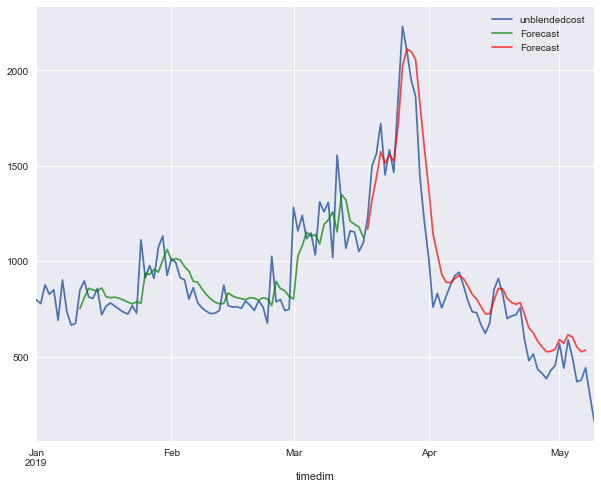

in sample
R^2 0.5707410933460042
mse 16724.865357428283
out of sample
R^2 0.9071565349782498
mse 22838.057598948384


In [142]:
current_best=[10,32,'relu',0.01]
current_best=[13,64,'relu',0.003]
current_best=[7,32,'relu',0.01]#bad
current_best=[10,64,'relu',0.0001]#best
#current_best=[7,64,'relu',0.0001]
n_steps=current_best[0]
model,X_train,Y_train=model_train_param(current_best)
temp=model_overfitting_check(model,current_best[0],X_train,Y_train)

- conclusion: no overfitting here, better out-sample effect than in-sample arima (higher R^2 and lower mse)
- question: R squared as a metric to check overfitting?

### verify with complete data (including extreme values)

In [143]:
#make prediction with test data (out of sample)
X_test = []
Y_test = [] 
test_x = np.array((daily_data_final['unblendedcost'])[train_size-n_steps:])
test_num=len(test_x)
for i in range(test_num-n_steps-1):
    X_test.append(test_x[i:i+n_steps].reshape(n_steps,-1))
    Y_test.append(test_x[i:i+n_steps].reshape(n_steps,-1))
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test,Y_test =X_test/1000,Y_test/1000

In [144]:
y_predict=model.predict(X_test)
data_temp2=daily_data_final.iloc[train_size-1:train_size-n_steps+test_num-2,].copy()
data_temp2.loc[:,'unblendedcost']=list((y_predict.reshape(-1))[list(range(n_steps-1,n_steps*(len(y_predict)+1)-1,n_steps))])
data_temp2.unblendedcost*=1000

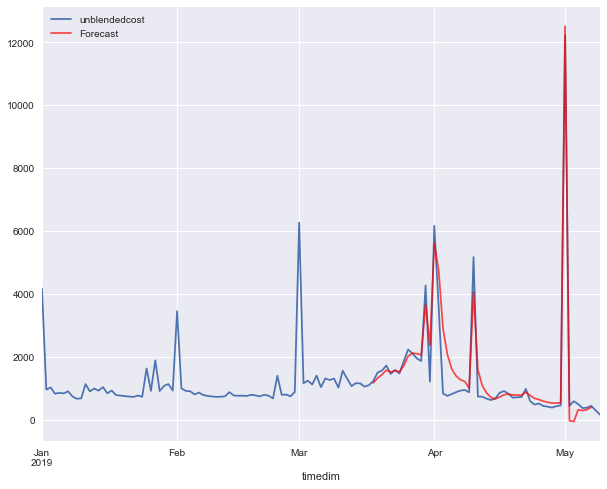

In [145]:
ax = daily_data_final.plot(label='actual with extreme value',figsize=(10,8))
(data_temp2.unblendedcost).plot(ax=ax, label='Forecast', alpha=0.7, color='red')
plt.legend()
plt.show()

In [146]:
print('out of sample')
r_squared = r2_score(daily_data_final.iloc[train_size-1:train_size-n_steps+test_num-2,], data_temp2.unblendedcost)
print('R^2 {}'.format(r_squared))
mse = mean_squared_error(daily_data_final.iloc[train_size-1:train_size-n_steps+test_num-2,], data_temp2.unblendedcost)
print('mse {}'.format(mse))

out of sample
R^2 0.9268850651627039
mse 270430.52299533196


- conclusion: 
- small lr and tanh combination has stability while may be trapped in local minimal
- large lr and relu combination has best out-sample prediction but not stable
- early stopping cases better than others
- possible solution: ensemble, adjust early-stopping part

# aggregate data according to productname

In [26]:
data = pd.get_dummies(df.drop(['productname'],axis=1))
data['productname']=df.productname
encoded = list(data.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
data=data.drop(data[to_drop], axis=1)
data.head()

611 total features after one-hot encoding.


timedim  usagequantity  unblendedcost  ys_usagetypegroup_Access  \
0 2019-01-01      986.00000        0.00000                         0   
1 2019-01-01      602.00000        0.00000                         0   
2 2019-01-01      583.00000        0.00000                         0   
3 2019-01-01        0.03226        0.03226                         0   
4 2019-01-01        0.09677        0.09677                         0   

   ys_usagetypegroup_Instance  ys_usagetypegroup_Load Balancer  \
0                           0                                0   
1                           0                                0   
2                           0                                0   
3                           0                                0   
4                           0                                0   

   ys_usagetypegroup_Network  ys_usagetypegroup_Others  \
0                          0                         1   
1                          0                         1   
2                          0                         1   
3                          0                         1   
4                          0                         1   

   ys_usagetypegroup_Reservation Purchased  ys_usagetypegroup_Storage  ...  \
0                                        0                          0  ...   
1                                        0                          0  ...   
2                                        0                          0  ...   
3                                        0                          0  ...   
4                                        0                          0  ...   

   ys_project_yotascale-forecasting-emr-logs  ys_project_yotascale-staging-2  \
0                                          0                               0   
1                                          0                               0   
2                                          0                               0   
3                                          0                               0   
4                                          0                               0   

   ys_project_yotascale-terraform-state  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   ys_project_yotascale-weekly-cost-report  ys_project_zookeeper-playground  \
0                                        0                                0   
1                                        0                                0   
2                                        0                                0   
3                                        0                                0   
4                                        0                                0   

   ys_type_Annual Fee  ys_type_Cost  ys_type_Support  reservedinstance_N  \
0                   0             1                0                   1   
1                   0             1                0                   1   
2                   0             1                0                   1   
3                   0             1                0                   1   
4                   0             1                0                   1   

                  productname  
0              AWS CloudTrail  
1              AWS CloudTrail  
2              AWS CloudTrail  
3  AWS Key Management Service  
4  AWS Key Management Service  

[5 rows x 535 columns]

In [28]:
#drop negative data
data=data[data.unblendedcost>=0]
#data=data[data.usagequantity>=0]

#drop 1 extreme data (formal data)
data2=data[data.unblendedcost<data.unblendedcost.max()]
#drop other extreme data as training set
#data3=data2[data2.unblendedcost<=5*data2.unblendedcost.std()+data2.unblendedcost.mean()]

- question: how to aggregate features?
- for some products, too little data, for example just one row? or just one row after aggregation

In [54]:
df[df.productname=='AWS CloudTrail'][df.timedim==df.timedim[0]]

timedim     productname ys_usagetypegroup operation       ys_region  \
0      2019-01-01  AWS CloudTrail            Others      None    ca-central-1   
1      2019-01-01  AWS CloudTrail            Others      None    eu-central-1   
2      2019-01-01  AWS CloudTrail            Others      None       us-east-2   
108067 2019-01-01  AWS CloudTrail            Others      None  ap-northeast-2   
108068 2019-01-01  AWS CloudTrail            Others      None       sa-east-1   
108069 2019-01-01  AWS CloudTrail            Others      None       us-west-2   
156572 2019-01-01  AWS CloudTrail            Others      None  ap-northeast-1   
156573 2019-01-01  AWS CloudTrail            Others      None  ap-southeast-2   
156574 2019-01-01  AWS CloudTrail            Others      None       eu-west-1   
156575 2019-01-01  AWS CloudTrail            Others      None       eu-west-2   
156576 2019-01-01  AWS CloudTrail            Others      None       eu-west-3   
156577 2019-01-01  AWS CloudTrail            Others      None       us-west-1   
205356 2019-01-01  AWS CloudTrail            Others      None      ap-south-1   
205357 2019-01-01  AWS CloudTrail            Others      None  ap-southeast-1   
205358 2019-01-01  AWS CloudTrail            Others      None      eu-north-1   
205359 2019-01-01  AWS CloudTrail            Others      None       us-east-1   

       ys_application  ys_owner ys_cluster ys_environment ys_operatinghours  \
0            Untagged  Untagged   Untagged       Untagged          Untagged   
1            Untagged  Untagged   Untagged       Untagged          Untagged   
2            Untagged  Untagged   Untagged       Untagged          Untagged   
108067       Untagged  Untagged   Untagged       Untagged          Untagged   
108068       Untagged  Untagged   Untagged       Untagged          Untagged   
108069       Untagged  Untagged   Untagged       Untagged          Untagged   
156572       Untagged  Untagged   Untagged       Untagged          Untagged   
156573       Untagged  Untagged   Untagged       Untagged          Untagged   
156574       Untagged  Untagged   Untagged       Untagged          Untagged   
156575       Untagged  Untagged   Untagged       Untagged          Untagged   
156576       Untagged  Untagged   Untagged       Untagged          Untagged   
156577       Untagged  Untagged   Untagged       Untagged          Untagged   
205356       Untagged  Untagged   Untagged       Untagged          Untagged   
205357       Untagged  Untagged   Untagged       Untagged          Untagged   
205358       Untagged  Untagged   Untagged       Untagged          Untagged   
205359       Untagged  Untagged   Untagged       Untagged          Untagged   

       ys_project ys_type  usagequantity  unblendedcost reservedinstance  
0        Untagged    Cost      986.00000        0.00000                N  
1        Untagged    Cost      602.00000        0.00000                N  
2        Untagged    Cost      583.00000        0.00000                N  
108067   Untagged    Cost      564.00000        0.00000                N  
108068   Untagged    Cost      562.00000        0.00000                N  
108069   Untagged    Cost     2317.00000        0.00000                N  
156572   Untagged    Cost      582.00000        0.00000                N  
156573   Untagged    Cost      565.00000        0.00000                N  
156574   Untagged    Cost      699.00000        0.00000                N  
156575   Untagged    Cost      580.00000        0.00000                N  
156576   Untagged    Cost      525.00000        0.00000                N  
156577   Untagged    Cost      561.00000        0.00000                N  
205356   Untagged    Cost      566.00000        0.00000                N  
205357   Untagged    Cost      564.00000        0.00000                N  
205358   Untagged    Cost      418.00000        0.00000                N  
205359   Untagged    Cost  3176521.00000        0.00000                N

In [55]:
df[df.productname=='APN Annual Program Fee'][df.timedim=='2019-03-30']

timedim             productname ys_usagetypegroup operation  \
204650 2019-03-30  APN Annual Program Fee            Others       NaN   

       ys_region ys_application  ys_owner ys_cluster ys_environment  \
204650       NaN       Untagged  Untagged   Untagged       Untagged   

       ys_operatinghours ys_project     ys_type  usagequantity  unblendedcost  \
204650          Untagged   Untagged  Annual Fee        1.00000     2500.00000   

       reservedinstance  
204650                N

In [44]:
data_temp=data2.groupby(['productname','timedim']).sum().dropna()

In [48]:
data_temp.head()

usagequantity  unblendedcost  \
productname            timedim                                    
APN Annual Program Fee 2019-03-30        1.00000     2500.00000   
AWS Budgets            2019-01-01        1.00000        0.00000   
                       2019-01-02        1.00000        0.00000   
                       2019-01-03        1.00000        0.00000   
                       2019-01-04        1.00000        0.00000   

                                   ys_usagetypegroup_Access  \
productname            timedim                                
APN Annual Program Fee 2019-03-30                   0.00000   
AWS Budgets            2019-01-01                   0.00000   
                       2019-01-02                   0.00000   
                       2019-01-03                   0.00000   
                       2019-01-04                   0.00000   

                                   ys_usagetypegroup_Instance  \
productname            timedim                                  
APN Annual Program Fee 2019-03-30                     0.00000   
AWS Budgets            2019-01-01                     0.00000   
                       2019-01-02                     0.00000   
                       2019-01-03                     0.00000   
                       2019-01-04                     0.00000   

                                   ys_usagetypegroup_Load Balancer  \
productname            timedim                                       
APN Annual Program Fee 2019-03-30                          0.00000   
AWS Budgets            2019-01-01                          0.00000   
                       2019-01-02                          0.00000   
                       2019-01-03                          0.00000   
                       2019-01-04                          0.00000   

                                   ys_usagetypegroup_Network  \
productname            timedim                                 
APN Annual Program Fee 2019-03-30                    0.00000   
AWS Budgets            2019-01-01                    0.00000   
                       2019-01-02                    0.00000   
                       2019-01-03                    0.00000   
                       2019-01-04                    0.00000   

                                   ys_usagetypegroup_Others  \
productname            timedim                                
APN Annual Program Fee 2019-03-30                   1.00000   
AWS Budgets            2019-01-01                   1.00000   
                       2019-01-02                   1.00000   
                       2019-01-03                   1.00000   
                       2019-01-04                   1.00000   

                                   ys_usagetypegroup_Reservation Purchased  \
productname            timedim                                               
APN Annual Program Fee 2019-03-30                                  0.00000   
AWS Budgets            2019-01-01                                  0.00000   
                       2019-01-02                                  0.00000   
                       2019-01-03                                  0.00000   
                       2019-01-04                                  0.00000   

                                   ys_usagetypegroup_Storage  \
productname            timedim                                 
APN Annual Program Fee 2019-03-30                    0.00000   
AWS Budgets            2019-01-01                    0.00000   
                       2019-01-02                    0.00000   
                       2019-01-03                    0.00000   
                       2019-01-04                    0.00000   

                                   ys_usagetypegroup_Unutilized Reservation  \
productname            timedim                                                
APN Annual Program Fee 2019-03-30                                   0.00000   
AWS Budgets            2019-01-01                   

In [47]:
data_temp.iloc[:,2:].max()

ys_usagetypegroup_Access                                                 631.00000
ys_usagetypegroup_Instance                                               140.00000
ys_usagetypegroup_Load Balancer                                           54.00000
ys_usagetypegroup_Network                                               1491.00000
ys_usagetypegroup_Others                                                 120.00000
ys_usagetypegroup_Reservation Purchased                                    1.00000
ys_usagetypegroup_Storage                                                167.00000
ys_usagetypegroup_Unutilized Reservation                                   3.00000
operation_A                                                                4.00000
operation_AAAA                                                             2.00000
operation_ANY                                                              2.00000
operation_AWSMPOCB                                                         0.00000
oper

In [33]:
#daily_product_data = data2.groupby(['productname','timedim'])['timedim','unblendedcost'].sum().dropna()

In [49]:
#productname_list=data2['productname'].drop_duplicates()

In [100]:
len(data_temp)

3579